In [1]:
# Importing packages
import pandas as pd
import numpy as np
import operator

In [36]:
# Importing preprocessed data sets
train = pd.read_csv('../preprocess_data/train.csv')
test = pd.read_csv('../preprocess_data/test.csv')

# Dropping the index column
train = train.drop(columns = 'Unnamed: 0')
test = test.drop(columns = 'Unnamed: 0')

# Removing rows with low frequency classes 
low_classes = ['Infiltration', 'Web Attack', 'Bot']
train_filtered = train[~train['Label'].isin(low_classes)]
test_filtered = test[~test['Label'].isin(low_classes)]

# Splitting in X and y 
X_train = train_filtered.iloc[:, :-1]
y_train = train_filtered.iloc[:, -1]
X_test = test_filtered.iloc[:, :-1]
y_test = test_filtered.iloc[:, -1]

# Replacing inf values with the maximum float number
X_train.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace = True)
X_train.fillna(X_train.mean(), inplace = True)
X_test.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace = True)
X_test.fillna(X_train.mean(), inplace = True) # using the mean of the training data to prevent data leakage 

In [35]:
train_filtered['Label'].value_counts()

Normal         318213
DoS/DdoS        53216
Portscan        22273
Brute Force      2026
Name: Label, dtype: int64

In [4]:
train['Label'].value_counts()

Normal          318213
DoS/DdoS         53216
Portscan         22273
Brute Force       2026
Web Attack         301
Bot                267
Infiltration         8
Name: Label, dtype: int64

In [37]:
test_filtered['Label'].value_counts()

Normal         136353
DoS/DdoS        22784
Portscan         9679
Brute Force       782
Name: Label, dtype: int64

# Feature Selection Using Information Gain

In [6]:
# Defining functions to calculate information gain
def entropy(labels):
    """Compute the entropy of a list of labels."""
    n_labels = len(labels)
    if n_labels <= 1:
        return 0
    value_counts = labels.value_counts() / n_labels
    entropy = -np.sum(value_counts * np.log2(value_counts))
    return entropy

def information_gain(data, labels, attribute):
    """Compute the information gain for a given attribute."""
    # Calculate total entropy before splitting
    total_entropy = entropy(labels)
    
    # Calculate the weighted entropy after splitting by the given attribute
    weighted_entropy = 0
    for value in attribute.unique():
        subset_labels = labels[attribute == value]
        weighted_entropy += (len(subset_labels) / len(labels)) * entropy(subset_labels)
    
    # Information gain is the difference between total entropy and weighted entropy
    info_gain = total_entropy - weighted_entropy
    return info_gain

In [7]:
# Computing information gain for each attribute
info_gain_dict = {}
for column in X_train:
    info_gain_dict[column] = information_gain(X_train, y_train, X_train[column])

In [8]:
# Printing the information gains in descending order
sorted(info_gain_dict.items(), key = operator.itemgetter(1), reverse = True)

[('Flow Bytes/s', 0.749575660474085),
 (' Average Packet Size', 0.7210720961131049),
 (' Packet Length Std', 0.7114068744812467),
 (' Flow Packets/s', 0.7091262924586844),
 (' Packet Length Variance', 0.7086814738225828),
 ('Fwd Packets/s', 0.7078221291751712),
 (' Packet Length Mean', 0.6813381209563407),
 (' Flow Duration', 0.6799469929037765),
 (' Flow IAT Mean', 0.6759735908705964),
 (' Bwd Packets/s', 0.6515293610668091),
 (' Flow IAT Max', 0.6324680364099486),
 (' Destination Port', 0.6261858478427469),
 (' Total Length of Bwd Packets', 0.6129016983249702),
 (' Subflow Bwd Bytes', 0.6129016983249702),
 (' Bwd Packet Length Mean', 0.5990190788269809),
 (' Avg Bwd Segment Size', 0.5990190788269809),
 ('Bwd Packet Length Max', 0.5591539096363304),
 ('Total Length of Fwd Packets', 0.5586232387164586),
 (' Subflow Fwd Bytes', 0.5586232387164586),
 (' Fwd IAT Mean', 0.55819068393859),
 (' Init_Win_bytes_backward', 0.5544966480848716),
 (' Fwd IAT Max', 0.5455262963059819),
 ('Init_Win_

### Feature Importance Plot 

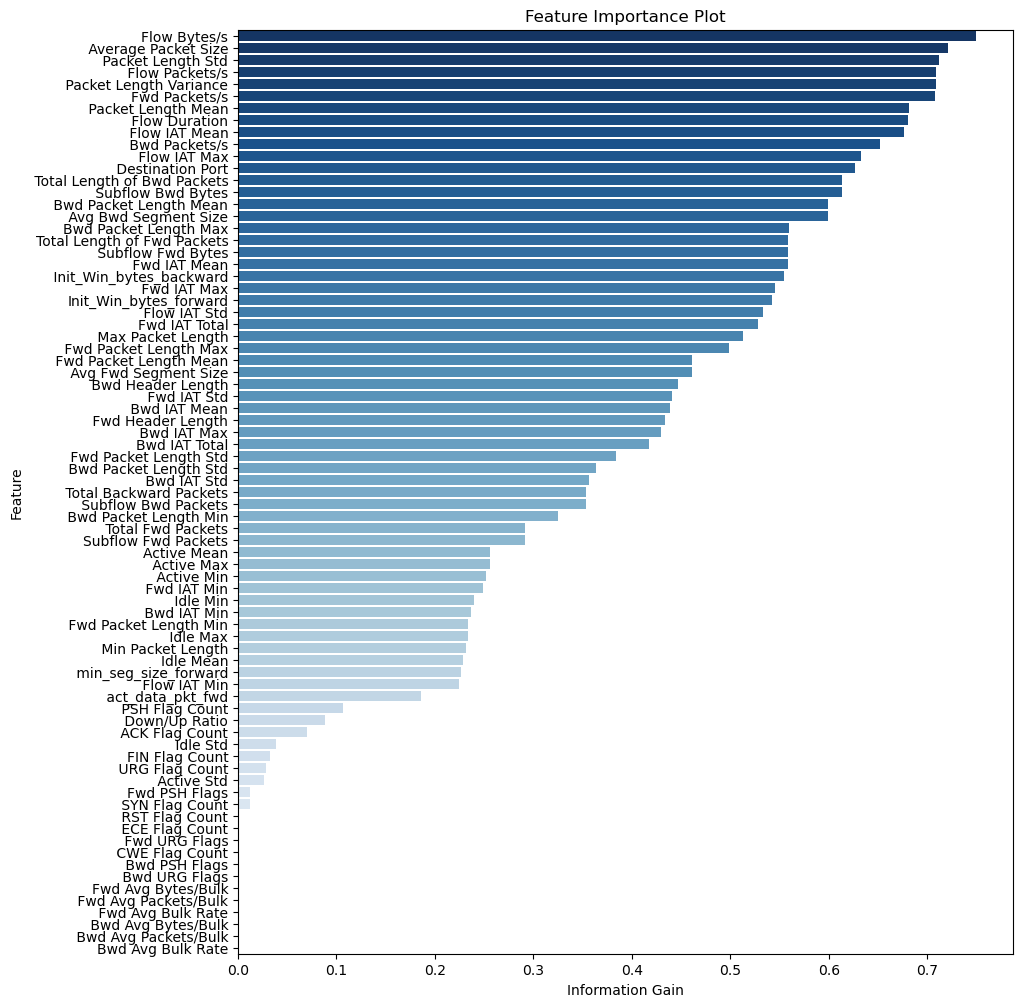

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the feature importance dictionary by information gain values
sorted_features = sorted(info_gain_dict.items(), key=lambda x: x[1], reverse=True)
features, gains = zip(*sorted_features)

# Convert features & information gains into lists
features = list(features)
gains = list(gains)

# Define custom shades of blue
custom_palette = sns.color_palette("Blues", len(gains))[::-1]

# Create the plot
plt.figure(figsize=(10, 12))
sns.barplot(x=gains, y=features, palette=custom_palette)

# Add labels and title
plt.xlabel("Information Gain")
plt.ylabel("Feature")
plt.title("Feature Importance Plot")

# Show plot
plt.show()


# Creating Feature Groups Based on Information Gain

In [113]:
# Creating feature groups using the same thresholds as the research paper
# Note: if a feature is greater than 0.6 then it will also be included in the greater 0.5, 0.4, 0.3, 0.2, and 0.1 groups
info_gain_gt06 = []
info_gain_gt05 = []
info_gain_gt04 = []
info_gain_gt03 = []
info_gain_gt02 = []
info_gain_gt01 = []
all_features = list(X_train.columns)

for key, val in info_gain_dict.items():
    if val > 0.6:
        info_gain_gt06.append(key)
    if val > 0.5: 
        info_gain_gt05.append(key)
    if val > 0.4:
        info_gain_gt04.append(key)
    if val > 0.3:
        info_gain_gt03.append(key)
    if val > 0.2:
        info_gain_gt02.append(key)
    if val > 0.1:
        info_gain_gt01.append(key)

In [11]:
# Printing the number of features in each Feature Group
print('Feature Groups:')
print(f'Information Gain > 0.6: {len(info_gain_gt06)}')
print(f'Information Gain > 0.5: {len(info_gain_gt05)}')
print(f'Information Gain > 0.4: {len(info_gain_gt04)}')
print(f'Information Gain > 0.3: {len(info_gain_gt03)}')
print(f'Information Gain > 0.2: {len(info_gain_gt02)}')
print(f'Information Gain > 0.1: {len(info_gain_gt01)}')
print(f'All Features: {len(all_features)}')

Feature Groups:
Information Gain > 0.6: 14
Information Gain > 0.5: 26
Information Gain > 0.4: 35
Information Gain > 0.3: 41
Information Gain > 0.2: 55
Information Gain > 0.1: 57
All Features: 77


# Building & Evaluating Classification Models for Each Feature Group

## Feature Group 1: Information Gain > 0.6

#### Random Forest

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings

# Data Preprocessing for Random Forest
warnings.filterwarnings('ignore')
## Converting categorical label column into numeric 
# Define a mapping dictionary for category to numeric value
#category_mapping = {'Normal': 0, 'Bot': 1, 'Brute Force': 2, 'DoS/DdoS': 3, 'Infiltration': 4, 'Portscan': 5, 'Web Attack': 6}
category_mapping = {'Normal': 0, 'Brute Force': 1, 'DoS/DdoS': 2, 'Portscan': 3}
class_names = list(category_mapping.keys())
# Map the categorical values to numeric values using the mapping dictionary
y_train_encoded = y_train.map(category_mapping)
y_test_encoded = y_test.map(category_mapping)

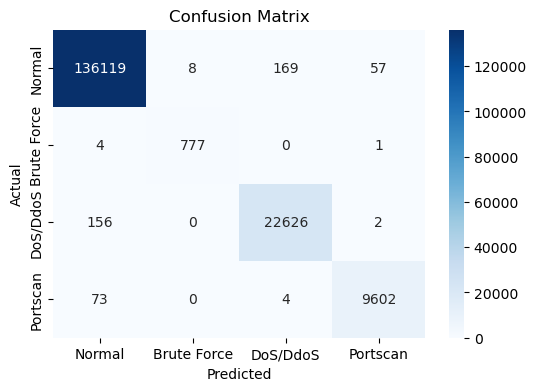

In [177]:
rf_start_fg1 = time.time()
# Training model with 10 fold cross-validation
rf_model_fg1 = RandomForestClassifier()

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [100]}
rf_grid_cv_fg1 = GridSearchCV(rf_model_fg1, param_grid, cv = 10)
rf_grid_cv_fg1.fit(X_train[info_gain_gt06], y_train_encoded.values.ravel())
rf_pred_fg1 = rf_grid_cv_fg1.predict(X_test[info_gain_gt06]) 
rf_end_fg1 = time.time()

# Confusion Matrix
rf_cm_fg1 = confusion_matrix(y_test_encoded.values.ravel(), rf_pred_fg1)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm_fg1, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [178]:
## Model Evaluation
# Accuracy
rf_accuracy_fg1 = accuracy_score(y_test_encoded.values.ravel(), rf_pred_fg1)

# Extract values from the confusion matrix
TN_rf_fg1, FP_rf_fg1, FN_rf_fg1, TP_rf_fg1 = rf_cm_fg1[0][0], rf_cm_fg1[0][1], rf_cm_fg1[1][0], rf_cm_fg1[1][1]

# Calculate False Positive Rate (FPR)
FPR_rf_fg1 = FP_rf_fg1 / (FP_rf_fg1 + TN_rf_fg1)

# Calculate True Positive Rate (TPR) or Recall
TPR_rf_fg1 = TP_rf_fg1 / (TP_rf_fg1 + FN_rf_fg1)

# Calculate Precision
Precision_rf_fg1 = TP_rf_fg1 / (TP_rf_fg1 + FP_rf_fg1)

# Calculate F1 Score
F1_score_rf_fg1 = 2 * (Precision_rf_fg1 * TPR_rf_fg1) / (Precision_rf_fg1 + TPR_rf_fg1)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rf_fg1 = (FP_rf_fg1 + FN_rf_fg1) / (TN_rf_fg1 + FP_rf_fg1 + FN_rf_fg1 + TP_rf_fg1)

# Print the results
print('Random Forest Accuracy', rf_accuracy_fg1)
print("Random Forest FPR:", FPR_rf_fg1)
print("Random Forest TPR (Recall):", TPR_rf_fg1)
print("Random Forest Precision:", Precision_rf_fg1)
print("Random Forest F1 Score:", F1_score_rf_fg1)
print("Random Forest PIC:", PIC_rf_fg1)
print("Random Forest Execution Time:", rf_end_fg1 - rf_start_fg1) 


Random Forest Accuracy 0.997205155721176
Random Forest FPR: 5.8768649863730195e-05
Random Forest TPR (Recall): 0.9948783610755442
Random Forest Precision: 0.9898089171974522
Random Forest F1 Score: 0.9923371647509579
Random Forest PIC: 8.765010079761592e-05
Random Forest Execution Time: 539.6935851573944


#### Random Tree

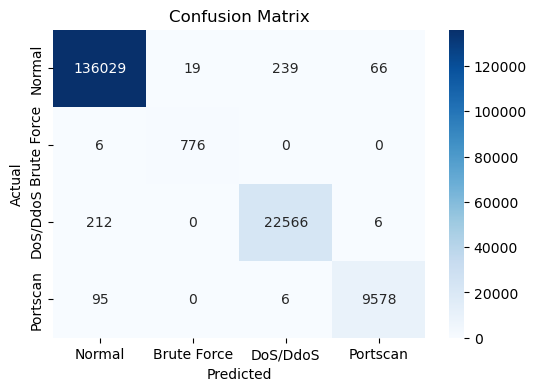

In [131]:
rt_start_fg1 = time.time()
# Training model with 10 fold cross-validation
rt_model_fg1 = RandomForestClassifier(n_estimators = 1)

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [1]}
rt_grid_cv_fg1 = GridSearchCV(rt_model_fg1, param_grid, cv = 10)
rt_grid_cv_fg1.fit(X_train[info_gain_gt06], y_train_encoded.values.ravel())
rt_pred_fg1 = rt_grid_cv_fg1.predict(X_test[info_gain_gt06]) 
rt_end_fg1 = time.time()

# Confusion Matrix
rt_cm_fg1 = confusion_matrix(y_test_encoded.values.ravel(), rt_pred_fg1)
plt.figure(figsize=(6, 4))
sns.heatmap(rt_cm_fg1, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [133]:
## Model Evaluation
# Accuracy
rt_accuracy_fg1 = accuracy_score(y_test_encoded.values.ravel(), rt_pred_fg1)

# Extract values from the confusion matrix
TN_rt_fg1, FP_rt_fg1, FN_rt_fg1, TP_rt_fg1 = rt_cm_fg1[0][0], rt_cm_fg1[0][1], rt_cm_fg1[1][0], rt_cm_fg1[1][1]

# Calculate False Positive Rate (FPR)
FPR_rt_fg1 = FP_rt_fg1 / (FP_rt_fg1+ TN_rt_fg1)

# Calculate True Positive Rate (TPR) or Recall
TPR_rt_fg1 = TP_rt_fg1 / (TP_rt_fg1 + FN_rt_fg1)

# Calculate Precision
Precision_rt_fg1 = TP_rt_fg1 / (TP_rt_fg1 + FP_rt_fg1)

# Calculate F1 Score
F1_score_rt_fg1 = 2 * (Precision_rt_fg1 * TPR_rt_fg1) / (Precision_rt_fg1 + TPR_rt_fg1)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rt_fg1 = (FP_rt_fg1 + FN_rt_fg1) / (TN_rt_fg1 + FP_rt_fg1 + FN_rt_fg1 + TP_rt_fg1)


# Print the results
print('Random Tree Accuracy', rt_accuracy_fg1)
print("Random Tree FPR:", FPR_rt_fg1)
print("Random Tree TPR (Recall):", TPR_rt_fg1)
print("Random Tree Precision:", Precision_rt_fg1)
print("Random Tree F1 Score:", F1_score_rt_fg1)
print("Random Tree PIC:", PIC_rt_fg1)
print("Random Tree Execution Time:", rt_end_fg1 - rt_start_fg1) 

Random Tree Accuracy 0.9961733039304709
Random Tree FPR: 0.00013965659179113253
Random Tree TPR (Recall): 0.9923273657289002
Random Tree Precision: 0.9761006289308176
Random Tree F1 Score: 0.984147114774889
Random Tree PIC: 0.0001827084703646861
Random Tree Execution Time: 5.973434209823608


#### Naive Bayes

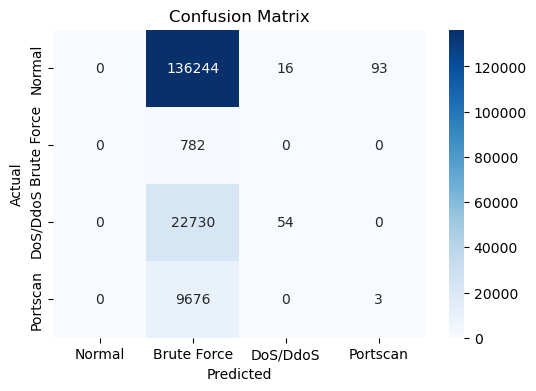

In [134]:
from sklearn.naive_bayes import GaussianNB
nb_start_fg1 = time.time()
# Training model with 10 fold cross-validation
nb_model_fg1 = GaussianNB()

# Performing cross-validation and making predictions
param_grid = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
nb_grid_cv_fg1 = GridSearchCV(nb_model_fg1, param_grid, cv = 10)
nb_grid_cv_fg1.fit(X_train[info_gain_gt06], y_train_encoded.values.ravel())
nb_pred_fg1 = nb_grid_cv_fg1.predict(X_test[info_gain_gt06]) 
nb_end_fg1 = time.time()

# Confusion Matrix
nb_cm_fg1 = confusion_matrix(y_test_encoded.values.ravel(), nb_pred_fg1)
plt.figure(figsize=(6, 4))
sns.heatmap(nb_cm_fg1, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [135]:
## Model Evaluation
# Accuracy
nb_accuracy_fg1 = accuracy_score(y_test_encoded.values.ravel(), nb_pred_fg1)

# Extract values from the confusion matrix
TN_nb_fg1, FP_nb_fg1, FN_nb_fg1, TP_nb_fg1 = nb_cm_fg1[0][0], nb_cm_fg1[0][1], nb_cm_fg1[1][0], nb_cm_fg1[1][1]

# Calculate False Positive Rate (FPR)
FPR_nb_fg1 = FP_nb_fg1 / (FP_nb_fg1 + TN_nb_fg1)

# Calculate True Positive Rate (TPR) or Recall
TPR_nb_fg1 = TP_nb_fg1 / (TP_nb_fg1 + FN_nb_fg1)

# Calculate Precision
Precision_nb_fg1 = TP_nb_fg1 / (TP_nb_fg1 + FP_nb_fg1)

# Calculate F1 Score
F1_score_nb_fg1 = 2 * (Precision_nb_fg1 * TPR_nb_fg1) / (Precision_nb_fg1 + TPR_nb_fg1)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_nb_fg1 = (FP_nb_fg1 + FN_nb_fg1) / (TN_nb_fg1 + FP_nb_fg1 + FN_nb_fg1 + TP_nb_fg1)


# Print the results
print('Naive Bayes Accuracy', nb_accuracy_fg1)
print("Naive Bayes FPR:", FPR_nb_fg1)
print("Naive Bayes TPR (Recall):", TPR_nb_fg1)
print("Naive Bayes Precision:", Precision_nb_fg1)
print("Naive Bayes F1 Score:", F1_score_nb_fg1)
print("Naive Bayes PIC:", PIC_nb_fg1)
print("Naive Bayes Execution Time:", nb_end_fg1 - nb_start_fg1) 

Naive Bayes Accuracy 0.004946992299437494
Naive Bayes FPR: 1.0
Naive Bayes TPR (Recall): 1.0
Naive Bayes Precision: 0.005706946127012392
Naive Bayes F1 Score: 0.011349123418088934
Naive Bayes PIC: 0.9942930538729876
Naive Bayes Execution Time: 2.4469728469848633


#### XGBoost

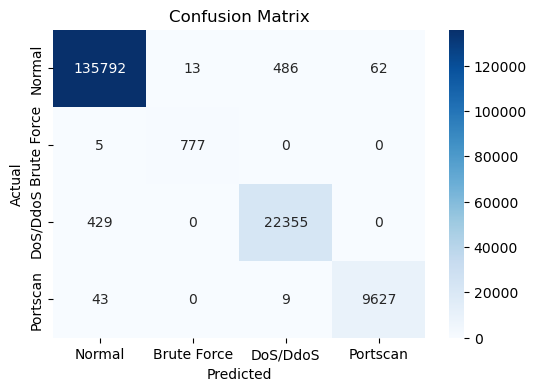

In [164]:
from xgboost import XGBClassifier
xgb_start_fg1 = time.time()
xgb_model_fg1 = XGBClassifier()
param_grid = {'max_depth': [3], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100], 'objective': ['binary:logistic'], 'eval_metric': ['logloss'], 'random_state': [0]}
xgb_grid_cv_fg1 = GridSearchCV(xgb_model_fg1, param_grid, cv = 10)
xgb_grid_cv_fg1.fit(X_train[info_gain_gt06], y_train_encoded.values.ravel())
xgb_pred_fg1 = xgb_grid_cv_fg1.predict(X_test[info_gain_gt06]) 
xgb_end_fg1 = time.time()

# Confusion Matrix
xgb_cm_fg1 = confusion_matrix(y_test_encoded.values.ravel(), xgb_pred_fg1)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm_fg1, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [166]:
## Model Evaluation
# Accuracy
xgb_accuracy_fg1 = accuracy_score(y_test_encoded.values.ravel(), xgb_pred_fg1)

# Extract values from the confusion matrix
TN_xgb_fg1, FP_xgb_fg1, FN_xgb_fg1, TP_xgb_fg1 = xgb_cm_fg1[0][0], xgb_cm_fg1[0][1], xgb_cm_fg1[1][0], xgb_cm_fg1[1][1]

# Calculate False Positive Rate (FPR)
FPR_xgb_fg1 = FP_xgb_fg1 / (FP_xgb_fg1 + TN_xgb_fg1)

# Calculate True Positive Rate (TPR) or Recall
TPR_xgb_fg1 = TP_xgb_fg1 / (TP_xgb_fg1 + FN_xgb_fg1)

# Calculate Precision
Precision_xgb_fg1 = TP_xgb_fg1 / (TP_xgb_fg1 + FP_xgb_fg1)

# Calculate F1 Score
F1_score_xgb_fg1 = 2 * (Precision_xgb_fg1 * TPR_xgb_fg1) / (Precision_xgb_fg1 + TPR_xgb_fg1)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_xgb_fg1 = (FP_xgb_fg1 + FN_xgb_fg1) / (TN_xgb_fg1 + FP_xgb_fg1 + FN_xgb_fg1 + TP_xgb_fg1)


# Print the results
print('XGBoost Accuracy', xgb_accuracy_fg1)
print("XGBoost FPR:", FPR_xgb_fg1)
print("XGBoost TPR (Recall):", TPR_xgb_fg1)
print("XGBoost Precision:", Precision_xgb_fg1)
print("XGBoost F1 Score:", F1_score_xgb_fg1)
print("XGBoost PIC:", PIC_xgb_fg1)
print("XGBoost Execution Time:", xgb_end_fg1 - xgb_start_fg1) 


XGBoost Accuracy 0.9938265781436102
XGBoost FPR: 9.572548875225507e-05
XGBoost TPR (Recall): 0.9936061381074168
XGBoost Precision: 0.9835443037974684
XGBoost F1 Score: 0.9885496183206107
XGBoost PIC: 0.00013178413758263964
XGBoost Execution Time: 731.4585559368134


## Feature Group 2: Information Gain > 0.5

#### Random Forest

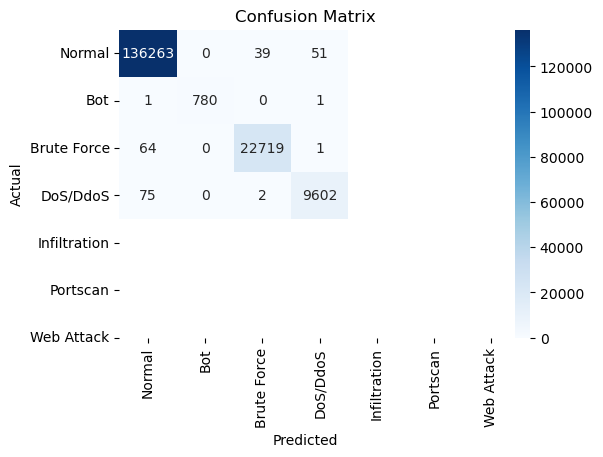

In [46]:
rf_start_fg2 = time.time()
# Training model with 10 fold cross-validation
rf_model_fg2 = RandomForestClassifier()

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [100]}
rf_grid_cv_fg2 = GridSearchCV(rf_model_fg2, param_grid, cv = 10)
rf_grid_cv_fg2.fit(X_train[info_gain_gt05], y_train_encoded.values.ravel())
rf_pred_fg2 = rf_grid_cv_fg2.predict(X_test[info_gain_gt05]) 
rf_end_fg2 = time.time()

# Confusion Matrix
rf_cm_fg2 = confusion_matrix(y_test_encoded.values.ravel(), rf_pred_fg2)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm_fg2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [48]:
## Model Evaluation
# Accuracy
rf_accuracy_fg2 = accuracy_score(y_test_encoded.values.ravel(), rf_pred_fg2)

# Extract values from the confusion matrix
TN_rf_fg2, FP_rf_fg2, FN_rf_fg2, TP_rf_fg2 = rf_cm_fg2[0][0], rf_cm_fg2[0][1], rf_cm_fg2[1][0], rf_cm_fg2[1][1]

# Calculate False Positive Rate (FPR)
FPR_rf_fg2 = FP_rf_fg2 / (FP_rf_fg2 + TN_rf_fg2)

# Calculate True Positive Rate (TPR) or Recall
TPR_rf_fg2 = TP_rf_fg2 / (TP_rf_fg2 + FN_rf_fg2)

# Calculate Precision
Precision_rf_fg2 = TP_rf_fg2 / (TP_rf_fg2 + FP_rf_fg2)

# Calculate F1 Score
F1_score_rf_fg2 = 2 * (Precision_rf_fg2 * TPR_rf_fg2) / (Precision_rf_fg2 + TPR_rf_fg2)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rf_fg2 = (FP_rf_fg2 + FN_rf_fg2) / (TN_rf_fg2 + FP_rf_fg2 + FN_rf_fg2 + TP_rf_fg2)


# Print the results
print('Random Forest Accuracy', rf_accuracy_fg2)
print("Random Forest FPR:", FPR_rf_fg2)
print("Random Forest TPR (Recall):", TPR_rf_fg2)
print("Random Forest Precision:", Precision_rf_fg2)
print("Random Forest F1 Score:", F1_score_rf_fg2)
print("Random Forest PIC:", PIC_rf_fg2)
print("Random Forest Execution Time:", rf_end_fg2 - rf_start_fg2) 


Random Forest Accuracy 0.9986202667484286
Random Forest FPR: 0.0
Random Forest TPR (Recall): 0.998719590268886
Random Forest Precision: 1.0
Random Forest F1 Score: 0.9993593850096092
Random Forest PIC: 7.296926534543651e-06
Random Forest Execution Time: 738.9772350788116


#### Random Tree

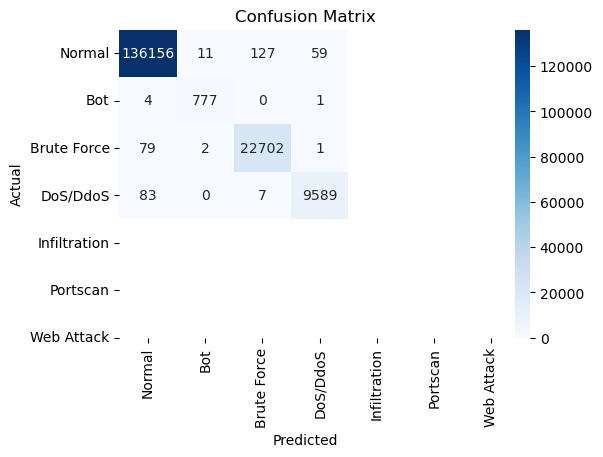

In [49]:
rt_start_fg2 = time.time()
# Training model with 10 fold cross-validation
rt_model_fg2 = RandomForestClassifier(n_estimators = 1)

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [1]}
rt_grid_cv_fg2 = GridSearchCV(rt_model_fg2, param_grid, cv = 10)
rt_grid_cv_fg2.fit(X_train[info_gain_gt05], y_train_encoded.values.ravel())
rt_pred_fg2 = rt_grid_cv_fg2.predict(X_test[info_gain_gt05]) 
rt_end_fg2 = time.time()

# Confusion Matrix
rt_cm_fg2 = confusion_matrix(y_test_encoded.values.ravel(), rt_pred_fg2)
plt.figure(figsize=(6, 4))
sns.heatmap(rt_cm_fg2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
## Model Evaluation
# Accuracy
rt_accuracy_fg2 = accuracy_score(y_test_encoded.values.ravel(), rt_pred_fg2)

# Extract values from the confusion matrix
TN_rt_fg2, FP_rt_fg2, FN_rt_fg2, TP_rt_fg2 = rt_cm_fg2[0][0], rt_cm_fg2[0][1], rt_cm_fg2[1][0], rt_cm_fg2[1][1]

# Calculate False Positive Rate (FPR)
FPR_rt_fg2 = FP_rt_fg2 / (FP_rt_fg2 + TN_rt_fg2)

# Calculate True Positive Rate (TPR) or Recall
TPR_rt_fg2 = TP_rt_fg2 / (TP_rt_fg2 + FN_rt_fg2)

# Calculate Precision
Precision_rt_fg2 = TP_rt_fg2 / (TP_rt_fg2 + FP_rt_fg2)

# Calculate F1 Score
F1_score_rt_fg2 = 2 * (Precision_rt_fg2 * TPR_rt_fg2) / (Precision_rt_fg2 + TPR_rt_fg2)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rt_fg2 = (FP_rt_fg2 + FN_rt_fg2) / (TN_rt_fg2 + FP_rt_fg2 + FN_rt_fg2 + TP_rt_fg2)


# Print the results
print('Random Tree Accuracy', rt_accuracy_fg2)
print("Random Tree FPR:", FPR_rt_fg2)
print("Random Tree TPR (Recall):", TPR_rt_fg2)
print("Random Tree Precision:", Precision_rt_fg2)
print("Random Tree F1 Score:", F1_score_rt_fg2)
print("Random Tree PIC:", PIC_rt_fg2)
print("Random Tree Execution Time:", rt_end_fg2 - rt_start_fg2) 

Random Tree Accuracy 0.9977947853158645
Random Tree FPR: 8.078315597758635e-05
Random Tree TPR (Recall): 0.9948783610755442
Random Tree Precision: 0.9860406091370558
Random Tree F1 Score: 0.9904397705544933
Random Tree PIC: 0.00010953062476268365
Random Tree Execution Time: 8.537869215011597


#### Naive Bayes

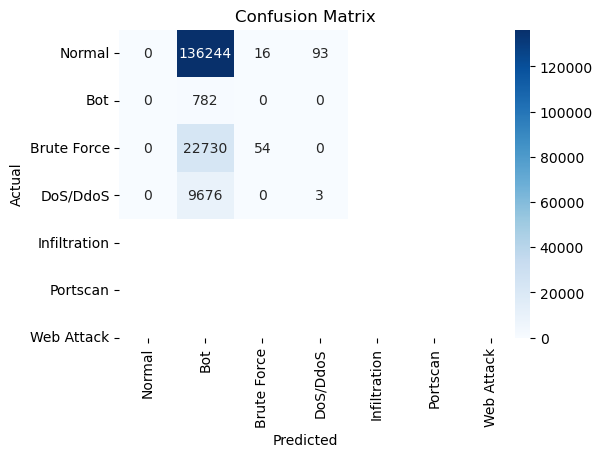

In [51]:
nb_start_fg2 = time.time()
# Training model with 10 fold cross-validation
nb_model_fg2 = GaussianNB()

# Performing cross-validation and making predictions
param_grid = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
nb_grid_cv_fg2 = GridSearchCV(nb_model_fg2, param_grid, cv = 10)
nb_grid_cv_fg2.fit(X_train[info_gain_gt05], y_train_encoded.values.ravel())
nb_pred_fg2 = nb_grid_cv_fg2.predict(X_test[info_gain_gt05]) 
nb_end_fg2 = time.time()

# Confusion Matrix
nb_cm_fg2 = confusion_matrix(y_test_encoded.values.ravel(), nb_pred_fg2)
plt.figure(figsize=(6, 4))
sns.heatmap(nb_cm_fg2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [52]:
## Model Evaluation
# Accuracy
nb_accuracy_fg2 = accuracy_score(y_test_encoded.values.ravel(), nb_pred_fg2)

# Extract values from the confusion matrix
TN_nb_fg2, FP_nb_fg2, FN_nb_fg2, TP_nb_fg2 = nb_cm_fg2[0][0], nb_cm_fg2[0][1], nb_cm_fg2[1][0], nb_cm_fg2[1][1]

# Calculate False Positive Rate (FPR)
FPR_nb_fg2 = FP_nb_fg2 / (FP_nb_fg2 + TN_nb_fg2)

# Calculate True Positive Rate (TPR) or Recall
TPR_nb_fg2 = TP_nb_fg2 / (TP_nb_fg2 + FN_nb_fg2)

# Calculate Precision
Precision_nb_fg2 = TP_nb_fg2 / (TP_nb_fg2 + FP_nb_fg2)

# Calculate F1 Score
F1_score_nb_fg2 = 2 * (Precision_nb_fg2 * TPR_nb_fg2) / (Precision_nb_fg2 + TPR_nb_fg2)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_nb_fg2 = (FP_nb_fg2 + FN_nb_fg2) / (TN_nb_fg2 + FP_nb_fg2 + FN_nb_fg2 + TP_nb_fg2)


# Print the results
print('Naive Bayes Accuracy', nb_accuracy_fg2)
print("Naive Bayes FPR:", FPR_nb_fg2)
print("Naive Bayes TPR (Recall):", TPR_nb_fg2)
print("Naive Bayes Precision:", Precision_nb_fg2)
print("Naive Bayes F1 Score:", F1_score_nb_fg2)
print("Naive Bayes PIC:", PIC_nb_fg2)
print("Naive Bayes Execution Time:", nb_end_fg2 - nb_start_fg2) 

Naive Bayes Accuracy 0.004946992299437494
Naive Bayes FPR: 1.0
Naive Bayes TPR (Recall): 1.0
Naive Bayes Precision: 0.005706946127012392
Naive Bayes F1 Score: 0.011349123418088934
Naive Bayes PIC: 0.9942930538729876
Naive Bayes Execution Time: 3.4270758628845215


#### XGBoost

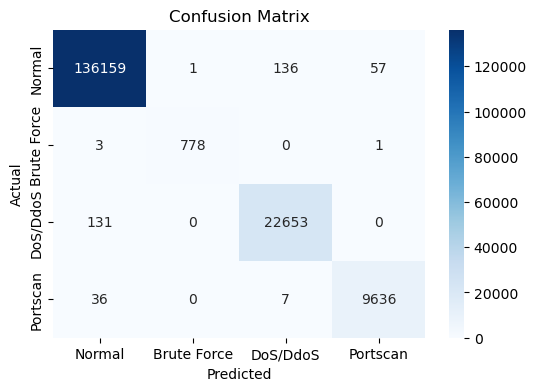

In [136]:
xgb_start_fg2 = time.time()
xgb_model_fg2 = XGBClassifier()
param_grid = {'max_depth': [3], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100], 'objective': ['binary:logistic'], 'eval_metric': ['logloss'], 'random_state': [0]}
xgb_grid_cv_fg2 = GridSearchCV(xgb_model_fg2, param_grid, cv = 10)
xgb_grid_cv_fg2.fit(X_train[info_gain_gt05], y_train_encoded.values.ravel())
xgb_pred_fg2 = xgb_grid_cv_fg2.predict(X_test[info_gain_gt05]) 
xgb_end_fg2 = time.time()

# Confusion Matrix
xgb_cm_fg2 = confusion_matrix(y_test_encoded.values.ravel(), xgb_pred_fg2)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm_fg2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [137]:
## Model Evaluation
# Accuracy
xgb_accuracy_fg2 = accuracy_score(y_test_encoded.values.ravel(), xgb_pred_fg2)

# Extract values from the confusion matrix
TN_xgb_fg2, FP_xgb_fg2, FN_xgb_fg2, TP_xgb_fg2 = xgb_cm_fg2[0][0], xgb_cm_fg2[0][1], xgb_cm_fg2[1][0], xgb_cm_fg2[1][1]

# Calculate False Positive Rate (FPR)
FPR_xgb_fg2 = FP_xgb_fg2 / (FP_xgb_fg2 + TN_xgb_fg2)

# Calculate True Positive Rate (TPR) or Recall
TPR_xgb_fg2 = TP_xgb_fg2 / (TP_xgb_fg2 + FN_xgb_fg2)

# Calculate Precision
Precision_xgb_fg2 = TP_xgb_fg2 / (TP_xgb_fg2 + FP_xgb_fg2)

# Calculate F1 Score
F1_score_xgb_fg2 = 2 * (Precision_xgb_fg2 * TPR_xgb_fg2) / (Precision_xgb_fg2 + TPR_xgb_fg2)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_xgb_fg2 = (FP_xgb_fg2 + FN_xgb_fg2) / (TN_xgb_fg2 + FP_xgb_fg2 + FN_xgb_fg2 + TP_xgb_fg2)


# Print the results
print('XGBoost Accuracy', xgb_accuracy_fg2)
print("XGBoost FPR:", FPR_xgb_fg2)
print("XGBoost TPR (Recall):", TPR_xgb_fg2)
print("XGBoost Precision:", Precision_xgb_fg2)
print("XGBoost F1 Score:", F1_score_xgb_fg2)
print("XGBoost PIC:", PIC_xgb_fg2)
print("XGBoost Execution Time:", xgb_end_fg2 - xgb_start_fg2) 


XGBoost Accuracy 0.9978065779077584
XGBoost FPR: 7.344300822561692e-06
XGBoost TPR (Recall): 0.9961587708066582
XGBoost Precision: 0.9987163029525032
XGBoost F1 Score: 0.9974358974358974
XGBoost PIC: 2.920965963444111e-05
XGBoost Execution Time: 1025.2206361293793


## Feature Group 3: Information Gain > 0.4

#### Random Forest

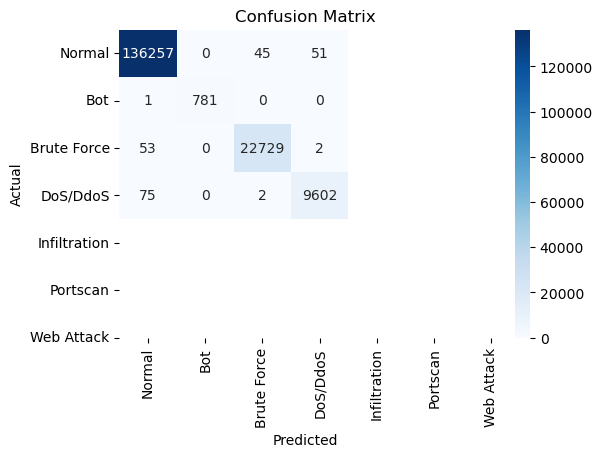

In [53]:
rf_start_fg3 = time.time()
# Training model with 10 fold cross-validation
rf_model_fg3 = RandomForestClassifier()

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [100]}
rf_grid_cv_fg3 = GridSearchCV(rf_model_fg3, param_grid, cv = 10)
rf_grid_cv_fg3.fit(X_train[info_gain_gt04], y_train_encoded.values.ravel())
rf_pred_fg3 = rf_grid_cv_fg3.predict(X_test[info_gain_gt04]) 
rf_end_fg3 = time.time()

# Confusion Matrix
rf_cm_fg3 = confusion_matrix(y_test_encoded.values.ravel(), rf_pred_fg3)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm_fg3, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [55]:
## Model Evaluation
# Accuracy
rf_accuracy_fg3 = accuracy_score(y_test_encoded.values.ravel(), rf_pred_fg3)

# Extract values from the confusion matrix
TN_rf_fg3, FP_rf_fg3, FN_rf_fg3, TP_rf_fg3 = rf_cm_fg3[0][0], rf_cm_fg3[0][1], rf_cm_fg3[1][0], rf_cm_fg3[1][1]

# Calculate False Positive Rate (FPR)
FPR_rf_fg3 = FP_rf_fg3 / (FP_rf_fg3 + TN_rf_fg3)

# Calculate True Positive Rate (TPR) or Recall
TPR_rf_fg3 = TP_rf_fg3 / (TP_rf_fg3 + FN_rf_fg3)

# Calculate Precision
Precision_rf_fg3 = TP_rf_fg3 / (TP_rf_fg3 + FP_rf_fg3)

# Calculate F1 Score
F1_score_rf_fg3 = 2 * (Precision_rf_fg3 * TPR_rf_fg3) / (Precision_rf_fg3 + TPR_rf_fg3)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rf_fg3 = (FP_rf_fg3 + FN_rf_fg3) / (TN_rf_fg3 + FP_rf_fg3 + FN_rf_fg3 + TP_rf_fg3)


# Print the results
print('Random Forest Accuracy', rf_accuracy_fg3)
print("Random Forest FPR:", FPR_rf_fg3)
print("Random Forest TPR (Recall):", TPR_rf_fg3)
print("Random Forest Precision:", Precision_rf_fg3)
print("Random Forest F1 Score:", F1_score_rf_fg3)
print("Random Forest PIC:", PIC_rf_fg3)
print("Random Forest Execution Time:", rf_end_fg3 - rf_start_fg3) 


Random Forest Accuracy 0.9986497482281631
Random Forest FPR: 0.0
Random Forest TPR (Recall): 0.9987212276214834
Random Forest Precision: 1.0
Random Forest F1 Score: 0.999360204734485
Random Forest PIC: 7.297192769941403e-06
Random Forest Execution Time: 713.0083720684052


#### Random Tree

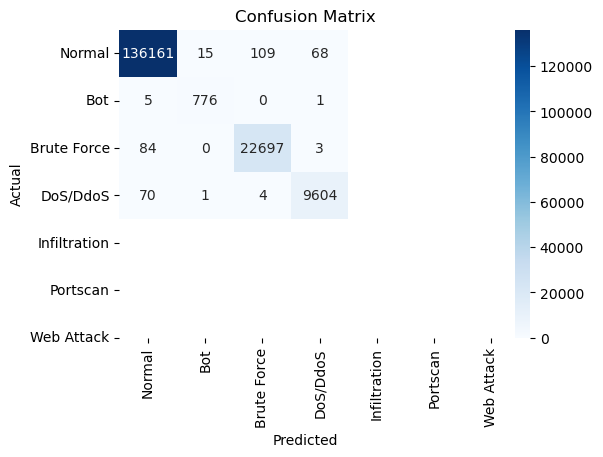

In [56]:
rt_start_fg3 = time.time()
# Training model with 10 fold cross-validation
rt_model_fg3 = RandomForestClassifier(n_estimators = 1)

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [1]}
rt_grid_cv_fg3 = GridSearchCV(rt_model_fg3, param_grid, cv = 10)
rt_grid_cv_fg3.fit(X_train[info_gain_gt04], y_train_encoded.values.ravel())
rt_pred_fg3 = rt_grid_cv_fg3.predict(X_test[info_gain_gt04]) 
rt_end_fg3 = time.time()

# Confusion Matrix
rt_cm_fg3 = confusion_matrix(y_test_encoded.values.ravel(), rt_pred_fg3)
plt.figure(figsize=(6, 4))
sns.heatmap(rt_cm_fg3, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [58]:
## Model Evaluation
# Accuracy
rt_accuracy_fg3 = accuracy_score(y_test_encoded.values.ravel(), rt_pred_fg3)

# Extract values from the confusion matrix
TN_rt_fg3, FP_rt_fg3, FN_rt_fg3, TP_rt_fg3 = rt_cm_fg3[0][0], rt_cm_fg3[0][1], rt_cm_fg3[1][0], rt_cm_fg3[1][1]

# Calculate False Positive Rate (FPR)
FPR_rt_fg3 = FP_rt_fg3 / (FP_rt_fg3 + TN_rt_fg3)

# Calculate True Positive Rate (TPR) or Recall
TPR_rt_fg3 = TP_rt_fg3 / (TP_rt_fg3 + FN_rt_fg3)

# Calculate Precision
Precision_rt_fg3 = TP_rt_fg3 / (TP_rt_fg3 + FP_rt_fg3)

# Calculate F1 Score
F1_score_rt_fg3 = 2 * (Precision_rt_fg3 * TPR_rt_fg3) / (Precision_rt_fg3 + TPR_rt_fg3)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rt_fg3 = (FP_rt_fg3 + FN_rt_fg3) / (TN_rt_fg3 + FP_rt_fg3 + FN_rt_fg3 + TP_rt_fg3)


# Print the results
print('Random Tree Accuracy', rt_accuracy_fg3)
print("Random Tree FPR:", FPR_rt_fg3)
print("Random Tree TPR (Recall):", TPR_rt_fg3)
print("Random Tree Precision:", Precision_rt_fg3)
print("Random Tree F1 Score:", F1_score_rt_fg3)
print("Random Tree PIC:", PIC_rt_fg3)
print("Random Tree Execution Time:", rt_end_fg3 - rt_start_fg3) 

Random Tree Accuracy 0.997877333459121
Random Tree FPR: 0.00011015156855833627
Random Tree TPR (Recall): 0.9935979513444302
Random Tree Precision: 0.9810366624525917
Random Tree F1 Score: 0.9872773536895674
Random Tree PIC: 0.0001460312360813978
Random Tree Execution Time: 7.8119261264801025


#### Naive Bayes

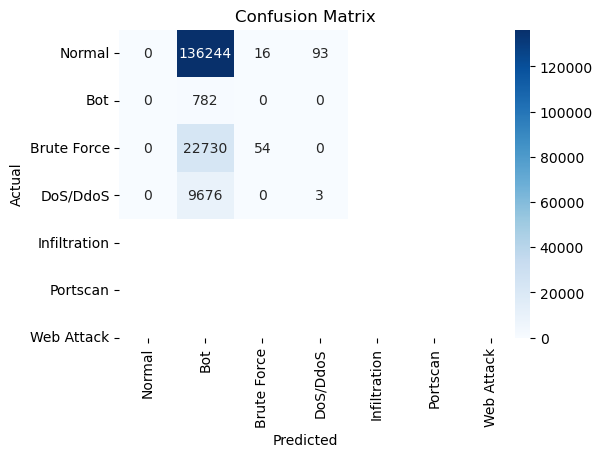

In [59]:
nb_start_fg3 = time.time()
# Training model with 10 fold cross-validation
nb_model_fg3 = GaussianNB()

# Performing cross-validation and making predictions
param_grid = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
nb_grid_cv_fg3 = GridSearchCV(nb_model_fg3, param_grid, cv = 10)
nb_grid_cv_fg3.fit(X_train[info_gain_gt04], y_train_encoded.values.ravel())
nb_pred_fg3 = nb_grid_cv_fg3.predict(X_test[info_gain_gt04]) 
nb_end_fg3 = time.time()

# Confusion Matrix
nb_cm_fg3 = confusion_matrix(y_test_encoded.values.ravel(), nb_pred_fg3)
plt.figure(figsize=(6, 4))
sns.heatmap(nb_cm_fg3, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [61]:
## Model Evaluation
# Accuracy
nb_accuracy_fg3 = accuracy_score(y_test_encoded.values.ravel(), nb_pred_fg3)

# Extract values from the confusion matrix
TN_nb_fg3, FP_nb_fg3, FN_nb_fg3, TP_nb_fg3 = nb_cm_fg3[0][0], nb_cm_fg3[0][1], nb_cm_fg3[1][0], nb_cm_fg3[1][1]

# Calculate False Positive Rate (FPR)
FPR_nb_fg3 = FP_nb_fg3 / (FP_nb_fg3 + TN_nb_fg3)

# Calculate True Positive Rate (TPR) or Recall
TPR_nb_fg3 = TP_nb_fg3 / (TP_nb_fg3 + FN_nb_fg3)

# Calculate Precision
Precision_nb_fg3 = TP_nb_fg3 / (TP_nb_fg3 + FP_nb_fg3)

# Calculate F1 Score
F1_score_nb_fg3 = 2 * (Precision_nb_fg3 * TPR_nb_fg3) / (Precision_nb_fg3 + TPR_nb_fg3)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_nb_fg3 = (FP_nb_fg3 + FN_nb_fg3) / (TN_nb_fg3 + FP_nb_fg3 + FN_nb_fg3 + TP_nb_fg3)


# Print the results
print('Naive Bayes Accuracy', nb_accuracy_fg3)
print("Naive Bayes FPR:", FPR_nb_fg3)
print("Naive Bayes TPR (Recall):", TPR_nb_fg3)
print("Naive Bayes Precision:", Precision_nb_fg3)
print("Naive Bayes F1 Score:", F1_score_nb_fg3)
print("Naive Bayes PIC:", PIC_nb_fg3)
print("Naive Bayes Execution Time:", nb_end_fg3 - nb_start_fg3) 

Naive Bayes Accuracy 0.004946992299437494
Naive Bayes FPR: 1.0
Naive Bayes TPR (Recall): 1.0
Naive Bayes Precision: 0.005706946127012392
Naive Bayes F1 Score: 0.011349123418088934
Naive Bayes PIC: 0.9942930538729876
Naive Bayes Execution Time: 4.868325710296631


#### XGBoost

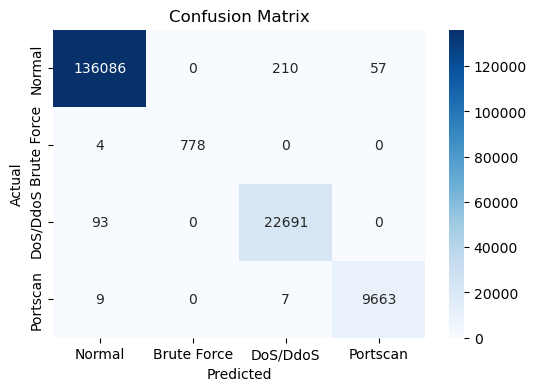

In [140]:
xgb_start_fg3 = time.time()
xgb_model_fg3 = XGBClassifier()
param_grid = {'max_depth': [3], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100], 'objective': ['binary:logistic'], 'eval_metric': ['logloss'], 'random_state': [0], 'n_jobs': [-1]}
xgb_grid_cv_fg3 = GridSearchCV(xgb_model_fg3, param_grid, cv = 10)
xgb_grid_cv_fg3.fit(X_train[info_gain_gt04], y_train_encoded.values.ravel())
xgb_pred_fg3 = xgb_grid_cv_fg3.predict(X_test[info_gain_gt04]) 
xgb_end_fg3 = time.time()

# Confusion Matrix
xgb_cm_fg3 = confusion_matrix(y_test_encoded.values.ravel(), xgb_pred_fg3)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm_fg3, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [143]:
## Model Evaluation
# Accuracy
xgb_accuracy_fg3 = accuracy_score(y_test_encoded.values.ravel(), xgb_pred_fg3)

# Extract values from the confusion matrix
TN_xgb_fg3, FP_xgb_fg3, FN_xgb_fg3, TP_xgb_fg3 = xgb_cm_fg3[0][0], xgb_cm_fg3[0][1], xgb_cm_fg3[1][0], xgb_cm_fg3[1][1]

# Calculate False Positive Rate (FPR)
FPR_xgb_fg3 = FP_xgb_fg3 / (FP_xgb_fg3 + TN_xgb_fg3)

# Calculate True Positive Rate (TPR) or Recall
TPR_xgb_fg3 = TP_xgb_fg3 / (TP_xgb_fg3 + FN_xgb_fg3)

# Calculate Precision
Precision_xgb_fg3 = TP_xgb_fg3 / (TP_xgb_fg3 + FP_xgb_fg3)

# Calculate F1 Score
F1_score_xgb_fg3 = 2 * (Precision_xgb_fg3 * TPR_xgb_fg3) / (Precision_xgb_fg3 + TPR_xgb_fg3)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_xgb_fg3 = (FP_xgb_fg3 + FN_xgb_fg3) / (TN_xgb_fg3 + FP_xgb_fg3 + FN_xgb_fg3 + TP_xgb_fg3)


# Print the results
print('XGBoost Accuracy', xgb_accuracy_fg3)
print("XGBoost FPR:", FPR_xgb_fg3)
print("XGBoost TPR (Recall):", TPR_xgb_fg3)
print("XGBoost Precision:", Precision_xgb_fg3)
print("XGBoost F1 Score:", F1_score_xgb_fg3)
print("XGBoost PIC:", PIC_xgb_fg3)
print("XGBoost Execution Time:", xgb_end_fg3 - xgb_start_fg3) 


XGBoost Accuracy 0.9976002075496173
XGBoost FPR: 0.0
XGBoost TPR (Recall): 0.9948849104859335
XGBoost Precision: 1.0
XGBoost F1 Score: 0.9974358974358974
XGBoost PIC: 2.922652014437901e-05
XGBoost Execution Time: 1236.6322209835052


## Feature Group 4: Information Gain > 0.3

#### Random Forest

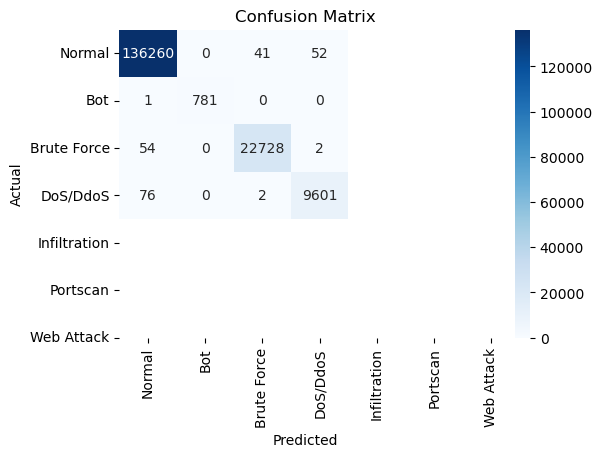

In [62]:
rf_start_fg4 = time.time()
# Training model with 10 fold cross-validation
rf_model_fg4 = RandomForestClassifier()

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [100]}
rf_grid_cv_fg4 = GridSearchCV(rf_model_fg4, param_grid, cv = 10)
rf_grid_cv_fg4.fit(X_train[info_gain_gt03], y_train_encoded.values.ravel())
rf_pred_fg4 = rf_grid_cv_fg4.predict(X_test[info_gain_gt03]) 
rf_end_fg4 = time.time()

# Confusion Matrix
rf_cm_fg4 = confusion_matrix(y_test_encoded.values.ravel(), rf_pred_fg4)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm_fg4, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [64]:
## Model Evaluation
# Accuracy
rf_accuracy_fg4 = accuracy_score(y_test_encoded.values.ravel(), rf_pred_fg4)

# Extract values from the confusion matrix
TN_rf_fg4, FP_rf_fg4, FN_rf_fg4, TP_rf_fg4 = rf_cm_fg4[0][0], rf_cm_fg4[0][1], rf_cm_fg4[1][0], rf_cm_fg4[1][1]

# Calculate False Positive Rate (FPR)
FPR_rf_fg4 = FP_rf_fg4 / (FP_rf_fg4 + TN_rf_fg4)

# Calculate True Positive Rate (TPR) or Recall
TPR_rf_fg4 = TP_rf_fg4 / (TP_rf_fg4 + FN_rf_fg4)

# Calculate Precision
Precision_rf_fg4 = TP_rf_fg4 / (TP_rf_fg4 + FP_rf_fg4)

# Calculate F1 Score
F1_score_rf_fg4 = 2 * (Precision_rf_fg4 * TPR_rf_fg4) / (Precision_rf_fg4 + TPR_rf_fg4)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rf_fg4 = (FP_rf_fg4 + FN_rf_fg4) / (TN_rf_fg4 + FP_rf_fg4 + FN_rf_fg4 + TP_rf_fg4)


# Print the results
print('Random Forest Accuracy', rf_accuracy_fg4)
print("Random Forest FPR:", FPR_rf_fg4)
print("Random Forest TPR (Recall):", TPR_rf_fg4)
print("Random Forest Precision:", Precision_rf_fg4)
print("Random Forest F1 Score:", F1_score_rf_fg4)
print("Random Forest PIC:", PIC_rf_fg4)
print("Random Forest Execution Time:", rf_end_fg4 - rf_start_fg4) 


Random Forest Accuracy 0.9986556445241099
Random Forest FPR: 0.0
Random Forest TPR (Recall): 0.9987212276214834
Random Forest Precision: 1.0
Random Forest F1 Score: 0.999360204734485
Random Forest PIC: 7.297033026371477e-06
Random Forest Execution Time: 808.4723899364471


#### Random Tree

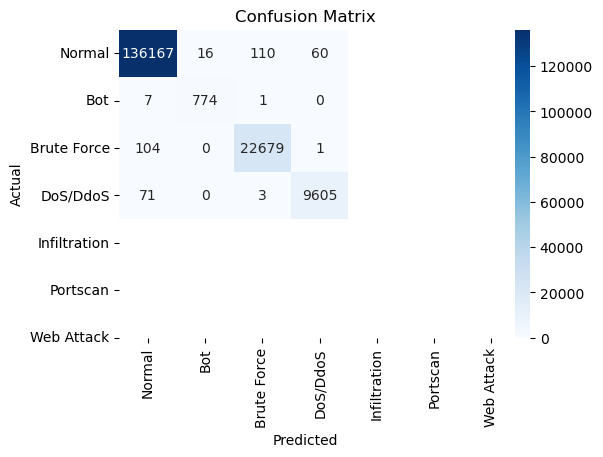

In [65]:
rt_start_fg4 = time.time()
# Training model with 10 fold cross-validation
rt_model_fg4 = RandomForestClassifier(n_estimators = 1)

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [1]}
rt_grid_cv_fg4 = GridSearchCV(rt_model_fg4, param_grid, cv = 10)
rt_grid_cv_fg4.fit(X_train[info_gain_gt03], y_train_encoded.values.ravel())
rt_pred_fg4 = rt_grid_cv_fg4.predict(X_test[info_gain_gt03]) 
rt_end_fg4 = time.time()

# Confusion Matrix
rt_cm_fg4 = confusion_matrix(y_test_encoded.values.ravel(), rt_pred_fg4)
plt.figure(figsize=(6, 4))
sns.heatmap(rt_cm_fg4, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [67]:
## Model Evaluation
# Accuracy
rt_accuracy_fg4 = accuracy_score(y_test_encoded.values.ravel(), rt_pred_fg4)

# Extract values from the confusion matrix
TN_rt_fg4, FP_rt_fg4, FN_rt_fg4, TP_rt_fg4 = rt_cm_fg4[0][0], rt_cm_fg4[0][1], rt_cm_fg4[1][0], rt_cm_fg4[1][1]

# Calculate False Positive Rate (FPR)
FPR_rt_fg4 = FP_rt_fg4 / (FP_rt_fg4 + TN_rt_fg4)

# Calculate True Positive Rate (TPR) or Recall
TPR_rt_fg4 = TP_rt_fg4 / (TP_rt_fg4 + FN_rt_fg4)

# Calculate Precision
Precision_rt_fg4 = TP_rt_fg4 / (TP_rt_fg4 + FP_rt_fg4)

# Calculate F1 Score
F1_score_rt_fg4 = 2 * (Precision_rt_fg4 * TPR_rt_fg4) / (Precision_rt_fg4 + TPR_rt_fg4)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rt_fg4 = (FP_rt_fg4 + FN_rt_fg4) / (TN_rt_fg4 + FP_rt_fg4 + FN_rt_fg4 + TP_rt_fg4)


# Print the results
print('Random Tree Accuracy', rt_accuracy_fg4)
print("Random Tree FPR:", FPR_rt_fg4)
print("Random Tree TPR (Recall):", TPR_rt_fg4)
print("Random Tree Precision:", Precision_rt_fg4)
print("Random Tree F1 Score:", F1_score_rt_fg4)
print("Random Tree PIC:", PIC_rt_fg4)
print("Random Tree Execution Time:", rt_end_fg4 - rt_start_fg4) 

Random Tree Accuracy 0.9978006816118115
Random Tree FPR: 0.0001174889670516878
Random Tree TPR (Recall): 0.9910371318822023
Random Tree Precision: 0.979746835443038
Random Tree F1 Score: 0.9853596435391471
Random Tree PIC: 0.00016792733857071932
Random Tree Execution Time: 9.18843698501587


#### Naive Bayes

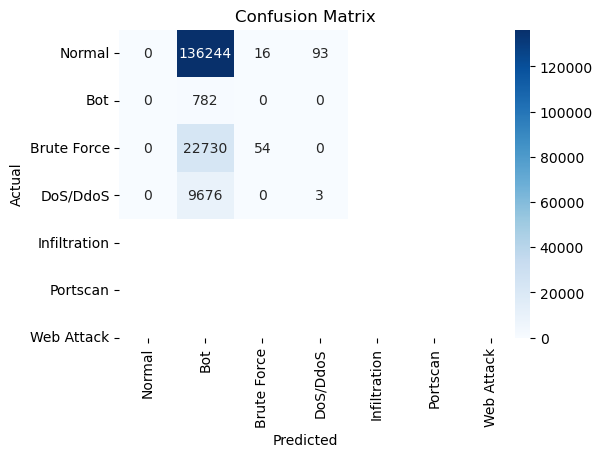

In [68]:
nb_start_fg4 = time.time()
# Training model with 10 fold cross-validation
nb_model_fg4 = GaussianNB()

# Performing cross-validation and making predictions
param_grid = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
nb_grid_cv_fg4 = GridSearchCV(nb_model_fg4, param_grid, cv = 10)
nb_grid_cv_fg4.fit(X_train[info_gain_gt03], y_train_encoded.values.ravel())
nb_pred_fg4 = nb_grid_cv_fg4.predict(X_test[info_gain_gt03]) 
nb_end_fg4 = time.time()

# Confusion Matrix
nb_cm_fg4 = confusion_matrix(y_test_encoded.values.ravel(), nb_pred_fg4)
plt.figure(figsize=(6, 4))
sns.heatmap(nb_cm_fg4, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [70]:
## Model Evaluation
# Accuracy
nb_accuracy_fg4 = accuracy_score(y_test_encoded.values.ravel(), nb_pred_fg4)

# Extract values from the confusion matrix
TN_nb_fg4, FP_nb_fg4, FN_nb_fg4, TP_nb_fg4 = nb_cm_fg4[0][0], nb_cm_fg4[0][1], nb_cm_fg4[1][0], nb_cm_fg4[1][1]

# Calculate False Positive Rate (FPR)
FPR_nb_fg4 = FP_nb_fg4 / (FP_nb_fg4 + TN_nb_fg4)

# Calculate True Positive Rate (TPR) or Recall
TPR_nb_fg4 = TP_nb_fg4 / (TP_nb_fg4 + FN_nb_fg4)

# Calculate Precision
Precision_nb_fg4 = TP_nb_fg4 / (TP_nb_fg4 + FP_nb_fg4)

# Calculate F1 Score
F1_score_nb_fg4 = 2 * (Precision_nb_fg4 * TPR_nb_fg4) / (Precision_nb_fg4 + TPR_nb_fg4)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_nb_fg4 = (FP_nb_fg4 + FN_nb_fg4) / (TN_nb_fg4 + FP_nb_fg4 + FN_nb_fg4 + TP_nb_fg4)


# Print the results
print('Naive Bayes Accuracy', nb_accuracy_fg4)
print("Naive Bayes FPR:", FPR_nb_fg4)
print("Naive Bayes TPR (Recall):", TPR_nb_fg4)
print("Naive Bayes Precision:", Precision_nb_fg4)
print("Naive Bayes F1 Score:", F1_score_nb_fg4)
print("Naive Bayes PIC:", PIC_nb_fg4)
print("Naive Bayes Execution Time:", nb_end_fg4 - nb_start_fg4) 

Naive Bayes Accuracy 0.004946992299437494
Naive Bayes FPR: 1.0
Naive Bayes TPR (Recall): 1.0
Naive Bayes Precision: 0.005706946127012392
Naive Bayes F1 Score: 0.011349123418088934
Naive Bayes PIC: 0.9942930538729876
Naive Bayes Execution Time: 4.889256000518799


#### XGBoost

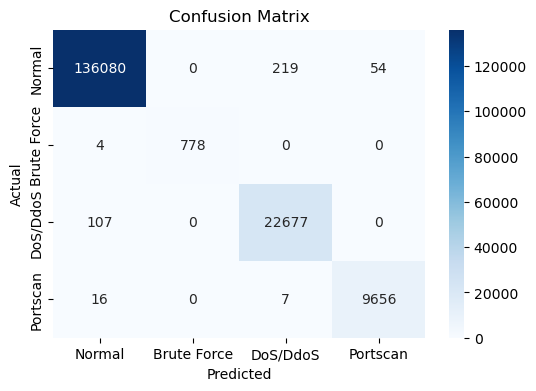

In [138]:
xgb_start_fg4 = time.time()
xgb_model_fg4 = XGBClassifier()
param_grid = {'max_depth': [3], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100], 'objective': ['binary:logistic'], 'eval_metric': ['logloss'], 'random_state': [0], 'n_jobs': [-1]}
xgb_grid_cv_fg4 = GridSearchCV(xgb_model_fg4, param_grid, cv = 10)
xgb_grid_cv_fg4.fit(X_train[info_gain_gt03], y_train_encoded.values.ravel())
xgb_pred_fg4 = xgb_grid_cv_fg4.predict(X_test[info_gain_gt03]) 
xgb_end_fg4 = time.time()

# Confusion Matrix
xgb_cm_fg4 = confusion_matrix(y_test_encoded.values.ravel(), xgb_pred_fg4)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm_fg4, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [142]:
## Model Evaluation
# Accuracy
xgb_accuracy_fg4 = accuracy_score(y_test_encoded.values.ravel(), xgb_pred_fg4)

# Extract values from the confusion matrix
TN_xgb_fg4, FP_xgb_fg4, FN_xgb_fg4, TP_xgb_fg4 = xgb_cm_fg4[0][0], xgb_cm_fg4[0][1], xgb_cm_fg4[1][0], xgb_cm_fg4[1][1]

# Calculate False Positive Rate (FPR)
FPR_xgb_fg4 = FP_xgb_fg4 / (FP_xgb_fg4 + TN_xgb_fg4)

# Calculate True Positive Rate (TPR) or Recall
TPR_xgb_fg4 = TP_xgb_fg4 / (TP_xgb_fg4 + FN_xgb_fg4)

# Calculate Precision
Precision_xgb_fg4 = TP_xgb_fg4 / (TP_xgb_fg4 + FP_xgb_fg4)

# Calculate F1 Score
F1_score_xgb_fg4 = 2 * (Precision_xgb_fg4 * TPR_xgb_fg4) / (Precision_xgb_fg4 + TPR_xgb_fg4)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_xgb_fg4 = (FP_xgb_fg4 + FN_xgb_fg4) / (TN_xgb_fg4 + FP_xgb_fg4 + FN_xgb_fg4 + TP_xgb_fg4)


# Print the results
print('XGBoost Accuracy', xgb_accuracy_fg4)
print("XGBoost FPR:", FPR_xgb_fg4)
print("XGBoost TPR (Recall):", TPR_xgb_fg4)
print("XGBoost Precision:", Precision_xgb_fg4)
print("XGBoost F1 Score:", F1_score_xgb_fg4)
print("XGBoost PIC:", PIC_xgb_fg4)
print("XGBoost Execution Time:", xgb_end_fg4 - xgb_start_fg4) 


XGBoost Accuracy 0.9977594075401832
XGBoost FPR: 0.0
XGBoost TPR (Recall): 0.9948849104859335
XGBoost Precision: 1.0
XGBoost F1 Score: 0.9974358974358974
XGBoost PIC: 2.922523891632814e-05
XGBoost Execution Time: 1429.669742822647


## Feature Group 5: Information Gain > 0.2

#### Random Forest

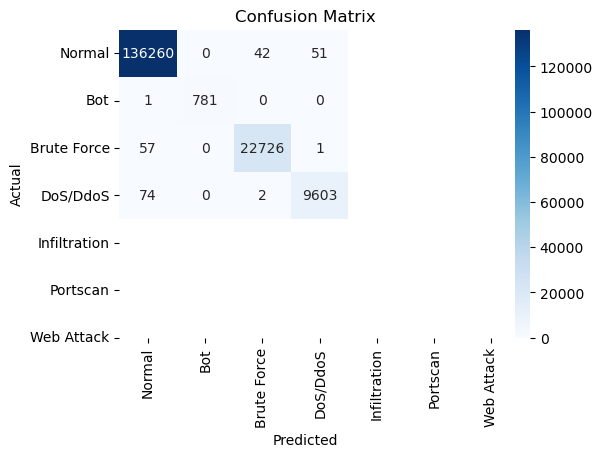

In [71]:
rf_start_fg5 = time.time()
# Training model with 10 fold cross-validation
rf_model_fg5 = RandomForestClassifier()

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [100]}
rf_grid_cv_fg5 = GridSearchCV(rf_model_fg5, param_grid, cv = 10)
rf_grid_cv_fg5.fit(X_train[info_gain_gt02], y_train_encoded.values.ravel())
rf_pred_fg5 = rf_grid_cv_fg5.predict(X_test[info_gain_gt02]) 
rf_end_fg5 = time.time()

# Confusion Matrix
rf_cm_fg5 = confusion_matrix(y_test_encoded.values.ravel(), rf_pred_fg5)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm_fg5, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [73]:
## Model Evaluation
# Accuracy
rf_accuracy_fg5 = accuracy_score(y_test_encoded.values.ravel(), rf_pred_fg5)

# Extract values from the confusion matrix
TN_rf_fg5, FP_rf_fg5, FN_rf_fg5, TP_rf_fg5 = rf_cm_fg5[0][0], rf_cm_fg5[0][1], rf_cm_fg5[1][0], rf_cm_fg5[1][1]

# Calculate False Positive Rate (FPR)
FPR_rf_fg5 = FP_rf_fg5 / (FP_rf_fg5 + TN_rf_fg5)

# Calculate True Positive Rate (TPR) or Recall
TPR_rf_fg5 = TP_rf_fg5 / (TP_rf_fg5 + FN_rf_fg5)

# Calculate Precision
Precision_rf_fg5 = TP_rf_fg5 / (TP_rf_fg5 + FP_rf_fg5)

# Calculate F1 Score
F1_score_rf_fg5 = 2 * (Precision_rf_fg5 * TPR_rf_fg5) / (Precision_rf_fg5 + TPR_rf_fg5)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rf_fg5 = (FP_rf_fg5 + FN_rf_fg5) / (TN_rf_fg5 + FP_rf_fg5 + FN_rf_fg5 + TP_rf_fg5)


# Print the results
print('Random Forest Accuracy', rf_accuracy_fg5)
print("Random Forest FPR:", FPR_rf_fg5)
print("Random Forest TPR (Recall):", TPR_rf_fg5)
print("Random Forest Precision:", Precision_rf_fg5)
print("Random Forest F1 Score:", F1_score_rf_fg5)
print("Random Forest PIC:", PIC_rf_fg5)
print("Random Forest Execution Time:", rf_end_fg5 - rf_start_fg5) 


Random Forest Accuracy 0.9986556445241099
Random Forest FPR: 0.0
Random Forest TPR (Recall): 0.9987212276214834
Random Forest Precision: 1.0
Random Forest F1 Score: 0.999360204734485
Random Forest PIC: 7.297033026371477e-06
Random Forest Execution Time: 917.9930818080902


#### Random Tree

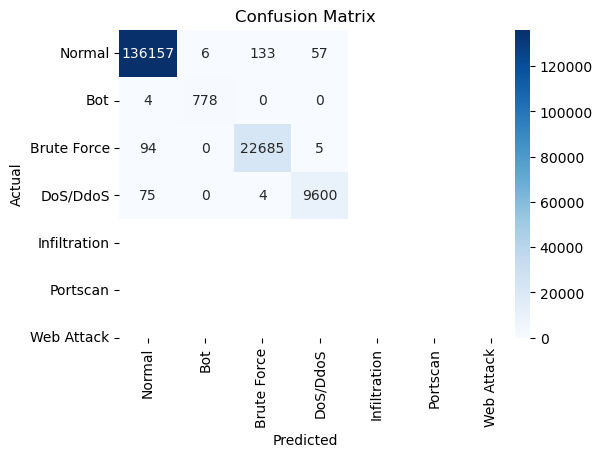

In [74]:
rt_start_fg5 = time.time()
# Training model with 10 fold cross-validation
rt_model_fg5 = RandomForestClassifier(n_estimators = 1)

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [1]}
rt_grid_cv_fg5 = GridSearchCV(rt_model_fg5, param_grid, cv = 10)
rt_grid_cv_fg5.fit(X_train[info_gain_gt02], y_train_encoded.values.ravel())
rt_pred_fg5 = rt_grid_cv_fg5.predict(X_test[info_gain_gt02]) 
rt_end_fg5 = time.time()

# Confusion Matrix
rt_cm_fg5 = confusion_matrix(y_test_encoded.values.ravel(), rt_pred_fg5)
plt.figure(figsize=(6, 4))
sns.heatmap(rt_cm_fg5, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [76]:
## Model Evaluation
# Accuracy
rt_accuracy_fg5 = accuracy_score(y_test_encoded.values.ravel(), rt_pred_fg5)

# Extract values from the confusion matrix
TN_rt_fg5, FP_rt_fg5, FN_rt_fg5, TP_rt_fg5 = rt_cm_fg5[0][0], rt_cm_fg5[0][1], rt_cm_fg5[1][0], rt_cm_fg5[1][1]

# Calculate False Positive Rate (FPR)
FPR_rt_fg5 = FP_rt_fg5 / (FP_rt_fg5 + TN_rt_fg5)

# Calculate True Positive Rate (TPR) or Recall
TPR_rt_fg5 = TP_rt_fg5 / (TP_rt_fg5 + FN_rt_fg5)

# Calculate Precision
Precision_rt_fg5 = TP_rt_fg5 / (TP_rt_fg5 + FP_rt_fg5)

# Calculate F1 Score
F1_score_rt_fg5 = 2 * (Precision_rt_fg5 * TPR_rt_fg5) / (Precision_rt_fg5 + TPR_rt_fg5)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rt_fg5 = (FP_rt_fg5 + FN_rt_fg5) / (TN_rt_fg5 + FP_rt_fg5 + FN_rt_fg5 + TP_rt_fg5)


# Print the results
print('Random Tree Accuracy', rt_accuracy_fg5)
print("Random Tree FPR:", FPR_rt_fg5)
print("Random Tree TPR (Recall):", TPR_rt_fg5)
print("Random Tree Precision:", Precision_rt_fg5)
print("Random Tree F1 Score:", F1_score_rt_fg5)
print("Random Tree PIC:", PIC_rt_fg5)
print("Random Tree Execution Time:", rt_end_fg5 - rt_start_fg5) 

Random Tree Accuracy 0.997771200132077
Random Tree FPR: 4.406483405917907e-05
Random Tree TPR (Recall): 0.9948849104859335
Random Tree Precision: 0.9923469387755102
Random Tree F1 Score: 0.9936143039591314
Random Tree PIC: 7.302201613786557e-05
Random Tree Execution Time: 10.926624059677124


#### Naive Bayes

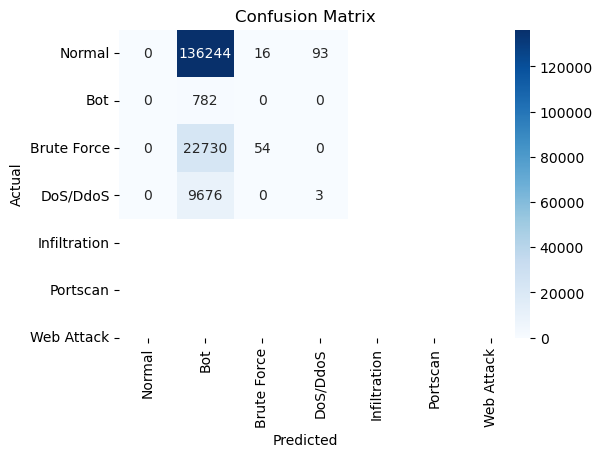

In [77]:
nb_start_fg5 = time.time()
# Training model with 10 fold cross-validation
nb_model_fg5 = GaussianNB()

# Performing cross-validation and making predictions
param_grid = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
nb_grid_cv_fg5 = GridSearchCV(nb_model_fg5, param_grid, cv = 10)
nb_grid_cv_fg5.fit(X_train[info_gain_gt02], y_train_encoded.values.ravel())
nb_pred_fg5 = nb_grid_cv_fg5.predict(X_test[info_gain_gt02]) 
nb_end_fg5 = time.time()

# Confusion Matrix
nb_cm_fg5 = confusion_matrix(y_test_encoded.values.ravel(), nb_pred_fg5)
plt.figure(figsize=(6, 4))
sns.heatmap(nb_cm_fg5, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [79]:
## Model Evaluation
# Accuracy
nb_accuracy_fg5 = accuracy_score(y_test_encoded.values.ravel(), nb_pred_fg5)

# Extract values from the confusion matrix
TN_nb_fg5, FP_nb_fg5, FN_nb_fg5, TP_nb_fg5 = nb_cm_fg5[0][0], nb_cm_fg5[0][1], nb_cm_fg5[1][0], nb_cm_fg5[1][1]

# Calculate False Positive Rate (FPR)
FPR_nb_fg5 = FP_nb_fg5 / (FP_nb_fg5 + TN_nb_fg5)

# Calculate True Positive Rate (TPR) or Recall
TPR_nb_fg5 = TP_nb_fg5 / (TP_nb_fg5 + FN_nb_fg5)

# Calculate Precision
Precision_nb_fg5 = TP_nb_fg5 / (TP_nb_fg5 + FP_nb_fg5)

# Calculate F1 Score
F1_score_nb_fg5 = 2 * (Precision_nb_fg5 * TPR_nb_fg5) / (Precision_nb_fg5 + TPR_nb_fg5)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_nb_fg5 = (FP_nb_fg5 + FN_nb_fg5) / (TN_nb_fg5 + FP_nb_fg5 + FN_nb_fg5 + TP_nb_fg5)


# Print the results
print('Naive Bayes Accuracy', nb_accuracy_fg5)
print("Naive Bayes FPR:", FPR_nb_fg5)
print("Naive Bayes TPR (Recall):", TPR_nb_fg5)
print("Naive Bayes Precision:", Precision_nb_fg5)
print("Naive Bayes F1 Score:", F1_score_nb_fg5)
print("Naive Bayes PIC:", PIC_nb_fg5)
print("Naive Bayes Execution Time:", nb_end_fg5 - nb_start_fg5) 

Naive Bayes Accuracy 0.004946992299437494
Naive Bayes FPR: 1.0
Naive Bayes TPR (Recall): 1.0
Naive Bayes Precision: 0.005706946127012392
Naive Bayes F1 Score: 0.011349123418088934
Naive Bayes PIC: 0.9942930538729876
Naive Bayes Execution Time: 9.020244836807251


#### XGBoost

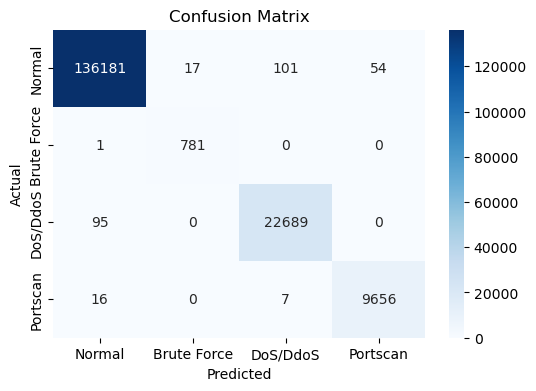

In [144]:
xgb_start_fg5 = time.time()
xgb_model_fg5 = XGBClassifier()
param_grid = {'max_depth': [3], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100], 'objective': ['binary:logistic'], 'eval_metric': ['logloss'], 'random_state': [0], 'n_jobs': [-1]}
xgb_grid_cv_fg5 = GridSearchCV(xgb_model_fg5, param_grid, cv = 10)
xgb_grid_cv_fg5.fit(X_train[info_gain_gt02], y_train_encoded.values.ravel())
xgb_pred_fg5 = xgb_grid_cv_fg5.predict(X_test[info_gain_gt02]) 
xgb_end_fg5 = time.time()

# Confusion Matrix
xgb_cm_fg5 = confusion_matrix(y_test_encoded.values.ravel(), xgb_pred_fg5)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm_fg5, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [145]:
## Model Evaluation
# Accuracy
xgb_accuracy_fg5 = accuracy_score(y_test_encoded.values.ravel(), xgb_pred_fg5)

# Extract values from the confusion matrix
TN_xgb_fg5, FP_xgb_fg5, FN_xgb_fg5, TP_xgb_fg5 = xgb_cm_fg5[0][0], xgb_cm_fg5[0][1], xgb_cm_fg5[1][0], xgb_cm_fg5[1][1]

# Calculate False Positive Rate (FPR)
FPR_xgb_fg5 = FP_xgb_fg5 / (FP_xgb_fg5 + TN_xgb_fg5)

# Calculate True Positive Rate (TPR) or Recall
TPR_xgb_fg5 = TP_xgb_fg5 / (TP_xgb_fg5 + FN_xgb_fg5)

# Calculate Precision
Precision_xgb_fg5 = TP_xgb_fg5 / (TP_xgb_fg5 + FP_xgb_fg5)

# Calculate F1 Score
F1_score_xgb_fg5 = 2 * (Precision_xgb_fg5 * TPR_xgb_fg5) / (Precision_xgb_fg5 + TPR_xgb_fg5)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_xgb_fg5 = (FP_xgb_fg5 + FN_xgb_fg5) / (TN_xgb_fg5 + FP_xgb_fg5 + FN_xgb_fg5 + TP_xgb_fg5)


# Print the results
print('XGBoost Accuracy', xgb_accuracy_fg5)
print("XGBoost FPR:", FPR_xgb_fg5)
print("XGBoost TPR (Recall):", TPR_xgb_fg5)
print("XGBoost Precision:", Precision_xgb_fg5)
print("XGBoost F1 Score:", F1_score_xgb_fg5)
print("XGBoost PIC:", PIC_xgb_fg5)
print("XGBoost Execution Time:", xgb_end_fg5 - xgb_start_fg5) 


XGBoost Accuracy 0.9982841778794561
XGBoost FPR: 0.0001248182792698865
XGBoost TPR (Recall): 0.9987212276214834
XGBoost Precision: 0.9786967418546366
XGBoost F1 Score: 0.9886075949367089
XGBoost PIC: 0.00013140604467805518
XGBoost Execution Time: 1621.662122964859


## Feature Group 6: Information Gain > 0.1

#### Random Forest

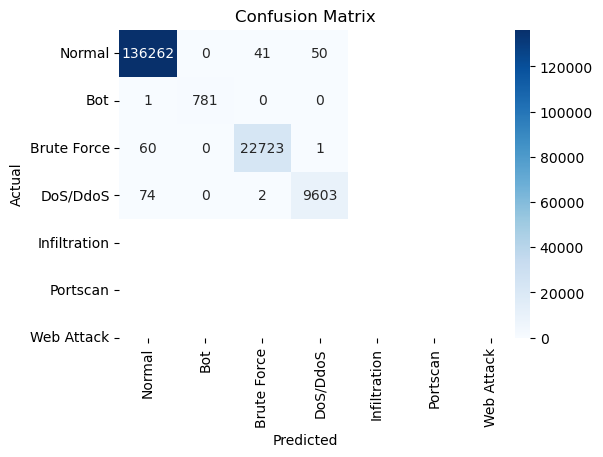

In [80]:
rf_start_fg6 = time.time()
# Training model with 10 fold cross-validation
rf_model_fg6 = RandomForestClassifier()

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [100]}
rf_grid_cv_fg6 = GridSearchCV(rf_model_fg6, param_grid, cv = 10)
rf_grid_cv_fg6.fit(X_train[info_gain_gt01], y_train_encoded.values.ravel())
rf_pred_fg6 = rf_grid_cv_fg6.predict(X_test[info_gain_gt01]) 
rf_end_fg6 = time.time()

# Confusion Matrix
rf_cm_fg6 = confusion_matrix(y_test_encoded.values.ravel(), rf_pred_fg6)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm_fg6, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [82]:
## Model Evaluation
# Accuracy
rf_accuracy_fg6 = accuracy_score(y_test_encoded.values.ravel(), rf_pred_fg6)

# Extract values from the confusion matrix
TN_rf_fg6, FP_rf_fg6, FN_rf_fg6, TP_rf_fg6 = rf_cm_fg6[0][0], rf_cm_fg6[0][1], rf_cm_fg6[1][0], rf_cm_fg6[1][1]

# Calculate False Positive Rate (FPR)
FPR_rf_fg6 = FP_rf_fg6 / (FP_rf_fg6 + TN_rf_fg6)

# Calculate True Positive Rate (TPR) or Recall
TPR_rf_fg6 = TP_rf_fg6 / (TP_rf_fg6 + FN_rf_fg6)

# Calculate Precision
Precision_rf_fg6 = TP_rf_fg6 / (TP_rf_fg6 + FP_rf_fg6)

# Calculate F1 Score
F1_score_rf_fg6 = 2 * (Precision_rf_fg6 * TPR_rf_fg6) / (Precision_rf_fg6 + TPR_rf_fg6)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rf_fg6 = (FP_rf_fg6 + FN_rf_fg6) / (TN_rf_fg6 + FP_rf_fg6 + FN_rf_fg6 + TP_rf_fg6)


# Print the results
print('Random Forest Accuracy', rf_accuracy_fg6)
print("Random Forest FPR:", FPR_rf_fg6)
print("Random Forest TPR (Recall):", TPR_rf_fg6)
print("Random Forest Precision:", Precision_rf_fg6)
print("Random Forest F1 Score:", F1_score_rf_fg6)
print("Random Forest PIC:", PIC_rf_fg6)
print("Random Forest Execution Time:", rf_end_fg6 - rf_start_fg6) 


Random Forest Accuracy 0.9986497482281631
Random Forest FPR: 0.0
Random Forest TPR (Recall): 0.9987212276214834
Random Forest Precision: 1.0
Random Forest F1 Score: 0.999360204734485
Random Forest PIC: 7.296926534543651e-06
Random Forest Execution Time: 819.4196858406067


#### Random Tree

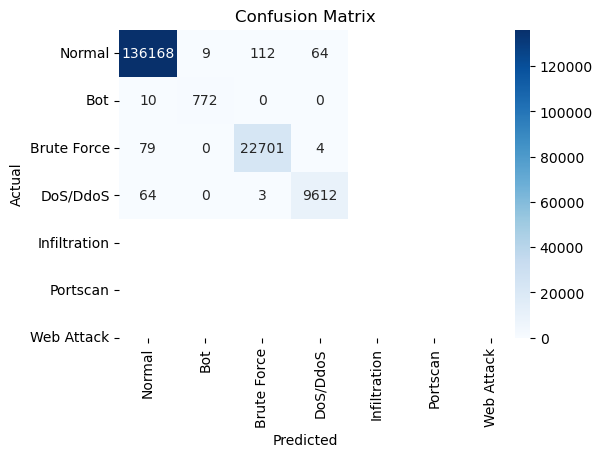

In [83]:
rt_start_fg6 = time.time()
# Training model with 10 fold cross-validation
rt_model_fg6 = RandomForestClassifier(n_estimators = 1)

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [1]}
rt_grid_cv_fg6 = GridSearchCV(rt_model_fg6, param_grid, cv = 10)
rt_grid_cv_fg6.fit(X_train[info_gain_gt01], y_train_encoded.values.ravel())
rt_pred_fg6 = rt_grid_cv_fg6.predict(X_test[info_gain_gt01]) 
rt_end_fg6 = time.time()

# Confusion Matrix
rt_cm_fg6 = confusion_matrix(y_test_encoded.values.ravel(), rt_pred_fg6)
plt.figure(figsize=(6, 4))
sns.heatmap(rt_cm_fg6, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [84]:
## Model Evaluation
# Accuracy
rt_accuracy_fg6 = accuracy_score(y_test_encoded.values.ravel(), rt_pred_fg6)

# Extract values from the confusion matrix
TN_rt_fg6, FP_rt_fg6, FN_rt_fg6, TP_rt_fg6 = rt_cm_fg6[0][0], rt_cm_fg6[0][1], rt_cm_fg6[1][0], rt_cm_fg6[1][1]

# Calculate False Positive Rate (FPR)
FPR_rt_fg6 = FP_rt_fg6 / (FP_rt_fg6 + TN_rt_fg6)

# Calculate True Positive Rate (TPR) or Recall
TPR_rt_fg6 = TP_rt_fg6 / (TP_rt_fg6 + FN_rt_fg6)

# Calculate Precision
Precision_rt_fg6 = TP_rt_fg6 / (TP_rt_fg6 + FP_rt_fg6)

# Calculate F1 Score
F1_score_rt_fg6 = 2 * (Precision_rt_fg6 * TPR_rt_fg6) / (Precision_rt_fg6 + TPR_rt_fg6)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rt_fg6 = (FP_rt_fg6 + FN_rt_fg6) / (TN_rt_fg6 + FP_rt_fg6 + FN_rt_fg6 + TP_rt_fg6)


# Print the results
print('Random Tree Accuracy', rt_accuracy_fg6)
print("Random Tree FPR:", FPR_rt_fg6)
print("Random Tree TPR (Recall):", TPR_rt_fg6)
print("Random Tree Precision:", Precision_rt_fg6)
print("Random Tree F1 Score:", F1_score_rt_fg6)
print("Random Tree PIC:", PIC_rt_fg6)
print("Random Tree Execution Time:", rt_end_fg6 - rt_start_fg6) 

Random Tree Accuracy 0.9979657778983243
Random Tree FPR: 6.609045580384353e-05
Random Tree TPR (Recall): 0.9872122762148338
Random Tree Precision: 0.9884763124199744
Random Tree F1 Score: 0.9878438899552143
Random Tree PIC: 0.00013872764842033018
Random Tree Execution Time: 11.06661081314087


#### Naive Bayes

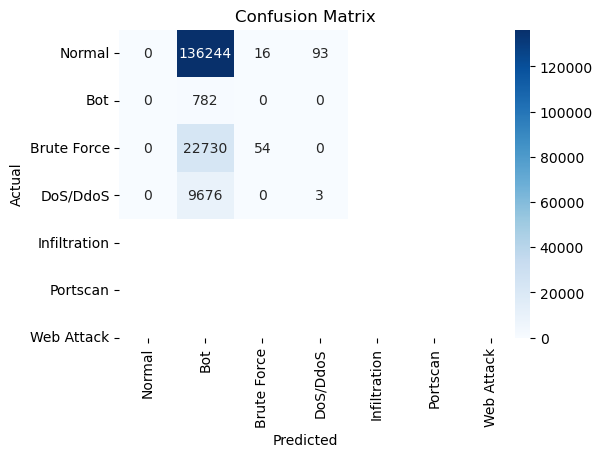

In [85]:
nb_start_fg6 = time.time()
# Training model with 10 fold cross-validation
nb_model_fg6 = GaussianNB()

# Performing cross-validation and making predictions
param_grid = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
nb_grid_cv_fg6 = GridSearchCV(nb_model_fg6, param_grid, cv = 10)
nb_grid_cv_fg6.fit(X_train[info_gain_gt01], y_train_encoded.values.ravel())
nb_pred_fg6 = nb_grid_cv_fg6.predict(X_test[info_gain_gt01]) 
nb_end_fg6 = time.time()

# Confusion Matrix
nb_cm_fg6 = confusion_matrix(y_test_encoded.values.ravel(), nb_pred_fg6)
plt.figure(figsize=(6, 4))
sns.heatmap(nb_cm_fg6, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [87]:
## Model Evaluation
# Accuracy
nb_accuracy_fg6 = accuracy_score(y_test_encoded.values.ravel(), nb_pred_fg6)

# Extract values from the confusion matrix
TN_nb_fg6, FP_nb_fg6, FN_nb_fg6, TP_nb_fg6 = nb_cm_fg6[0][0], nb_cm_fg6[0][1], nb_cm_fg6[1][0], nb_cm_fg6[1][1]

# Calculate False Positive Rate (FPR)
FPR_nb_fg6 = FP_nb_fg6 / (FP_nb_fg6 + TN_nb_fg6)

# Calculate True Positive Rate (TPR) or Recall
TPR_nb_fg6 = TP_nb_fg6 / (TP_nb_fg6 + FN_nb_fg6)

# Calculate Precision
Precision_nb_fg6 = TP_nb_fg6 / (TP_nb_fg6 + FP_nb_fg6)

# Calculate F1 Score
F1_score_nb_fg6 = 2 * (Precision_nb_fg6 * TPR_nb_fg6) / (Precision_nb_fg6 + TPR_nb_fg6)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_nb_fg6 = (FP_nb_fg6 + FN_nb_fg6) / (TN_nb_fg6 + FP_nb_fg6 + FN_nb_fg6 + TP_nb_fg6)


# Print the results
print('Naive Bayes Accuracy', nb_accuracy_fg6)
print("Naive Bayes FPR:", FPR_nb_fg6)
print("Naive Bayes TPR (Recall):", TPR_nb_fg6)
print("Naive Bayes Precision:", Precision_nb_fg6)
print("Naive Bayes F1 Score:", F1_score_nb_fg6)
print("Naive Bayes PIC:", PIC_nb_fg6)
print("Naive Bayes Execution Time:", nb_end_fg6 - nb_start_fg6) 

Naive Bayes Accuracy 0.004946992299437494
Naive Bayes FPR: 1.0
Naive Bayes TPR (Recall): 1.0
Naive Bayes Precision: 0.005706946127012392
Naive Bayes F1 Score: 0.011349123418088934
Naive Bayes PIC: 0.9942930538729876
Naive Bayes Execution Time: 11.03832483291626


#### XGBoost

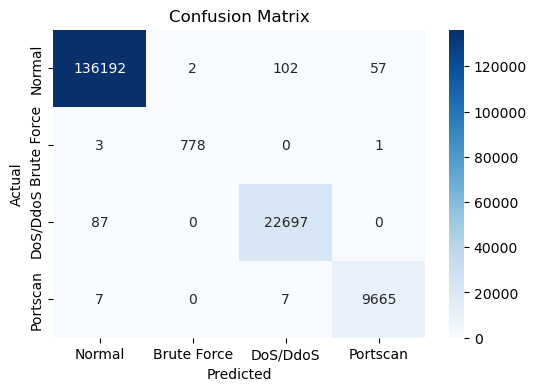

In [146]:
xgb_start_fg6 = time.time()
xgb_model_fg6 = XGBClassifier()
param_grid = {'max_depth': [3], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100], 'objective': ['binary:logistic'], 'eval_metric': ['logloss'], 'random_state': [0], 'n_jobs': [-1]}
xgb_grid_cv_fg6 = GridSearchCV(xgb_model_fg6, param_grid, cv = 10)
xgb_grid_cv_fg6.fit(X_train[info_gain_gt01], y_train_encoded.values.ravel())
xgb_pred_fg6 = xgb_grid_cv_fg6.predict(X_test[info_gain_gt01]) 
xgb_end_fg6 = time.time()

# Confusion Matrix
xgb_cm_fg6 = confusion_matrix(y_test_encoded.values.ravel(), xgb_pred_fg6)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm_fg6, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [147]:
## Model Evaluation
# Accuracy
xgb_accuracy_fg6 = accuracy_score(y_test_encoded.values.ravel(), xgb_pred_fg6)

# Extract values from the confusion matrix
TN_xgb_fg6, FP_xgb_fg6, FN_xgb_fg6, TP_xgb_fg6 = xgb_cm_fg6[0][0], xgb_cm_fg6[0][1], xgb_cm_fg6[1][0], xgb_cm_fg6[1][1]

# Calculate False Positive Rate (FPR)
FPR_xgb_fg6 = FP_xgb_fg6 / (FP_xgb_fg6 + TN_xgb_fg6)

# Calculate True Positive Rate (TPR) or Recall
TPR_xgb_fg6 = TP_xgb_fg6 / (TP_xgb_fg6 + FN_xgb_fg6)

# Calculate Precision
Precision_xgb_fg6 = TP_xgb_fg6 / (TP_xgb_fg6 + FP_xgb_fg6)

# Calculate F1 Score
F1_score_xgb_fg6 = 2 * (Precision_xgb_fg6 * TPR_xgb_fg6) / (Precision_xgb_fg6 + TPR_xgb_fg6)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_xgb_fg6 = (FP_xgb_fg6 + FN_xgb_fg6) / (TN_xgb_fg6 + FP_xgb_fg6 + FN_xgb_fg6 + TP_xgb_fg6)


# Print the results
print('XGBoost Accuracy', xgb_accuracy_fg6)
print("XGBoost FPR:", FPR_xgb_fg6)
print("XGBoost TPR (Recall):", TPR_xgb_fg6)
print("XGBoost Precision:", Precision_xgb_fg6)
print("XGBoost F1 Score:", F1_score_xgb_fg6)
print("XGBoost PIC:", PIC_xgb_fg6)
print("XGBoost Execution Time:", xgb_end_fg6 - xgb_start_fg6) 


XGBoost Accuracy 0.9984315852781283
XGBoost FPR: 1.4684934725465146e-05
XGBoost TPR (Recall): 0.9961587708066582
XGBoost Precision: 0.9974358974358974
XGBoost F1 Score: 0.9967969250480462
XGBoost PIC: 3.650301149844862e-05
XGBoost Execution Time: 1599.056304216385


## Feature Group 7: All Features

#### Random Forest

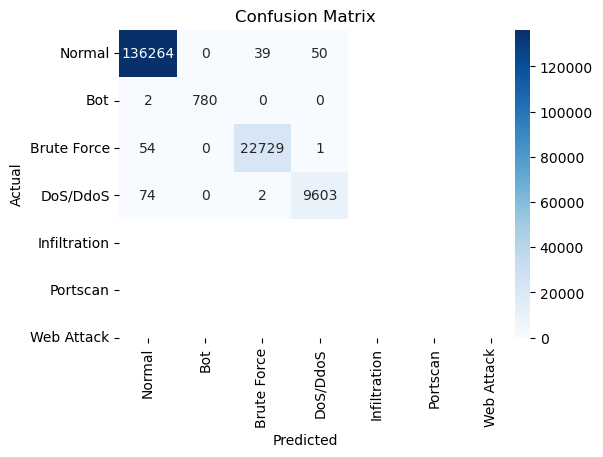

In [88]:
rf_start_fg7 = time.time()
# Training model with 10 fold cross-validation
rf_model_fg7 = RandomForestClassifier()

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [100]}
rf_grid_cv_fg7 = GridSearchCV(rf_model_fg7, param_grid, cv = 10)
rf_grid_cv_fg7.fit(X_train, y_train_encoded.values.ravel())
rf_pred_fg7 = rf_grid_cv_fg7.predict(X_test) 
rf_end_fg7 = time.time()

# Confusion Matrix
rf_cm_fg7 = confusion_matrix(y_test_encoded.values.ravel(), rf_pred_fg7)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm_fg7, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [165]:
## Model Evaluation
# Accuracy
rf_accuracy_fg7 = accuracy_score(y_test_encoded.values.ravel(), rf_pred_fg7)

# Extract values from the confusion matrix
TN_rf_fg7, FP_rf_fg7, FN_rf_fg7, TP_rf_fg7 = rf_cm_fg7[0][0], rf_cm_fg7[0][1], rf_cm_fg7[1][0], rf_cm_fg7[1][1]

# Calculate False Positive Rate (FPR)
FPR_rf_fg7 = FP_rf_fg7 / (FP_rf_fg7 + TN_rf_fg7)

# Calculate True Positive Rate (TPR) or Recall
TPR_rf_fg7 = TP_rf_fg7 / (TP_rf_fg7 + FN_rf_fg7)

# Calculate Precision
Precision_rf_fg7 = TP_rf_fg7 / (TP_rf_fg7 + FP_rf_fg7)

# Calculate F1 Score
F1_score_rf_fg7 = 2 * (Precision_rf_fg7 * TPR_rf_fg7) / (Precision_rf_fg7 + TPR_rf_fg7)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rf_fg7 = (FP_rf_fg7 + FN_rf_fg7) / (TN_rf_fg7 + FP_rf_fg7 + FN_rf_fg7 + TP_rf_fg7)


# Print the results
print('Random Forest Accuracy', rf_accuracy_fg7)
print("Random Forest FPR:", FPR_rf_fg7)
print("Random Forest TPR (Recall):", TPR_rf_fg7)
print("Random Forest Precision:", Precision_rf_fg7)
print("Random Forest F1 Score:", F1_score_rf_fg7)
print("Random Forest PIC:", PIC_rf_fg7)
print("Random Forest Execution Time:", rf_end_fg7 - rf_start_fg7) 


Random Forest Accuracy 0.8034646634983903
Random Forest FPR: 0.0
Random Forest TPR (Recall): 0.9974424552429667
Random Forest Precision: 1.0
Random Forest F1 Score: 0.998719590268886
Random Forest PIC: 1.459364009164806e-05
Random Forest Execution Time: 683.1859188079834


#### Random Tree

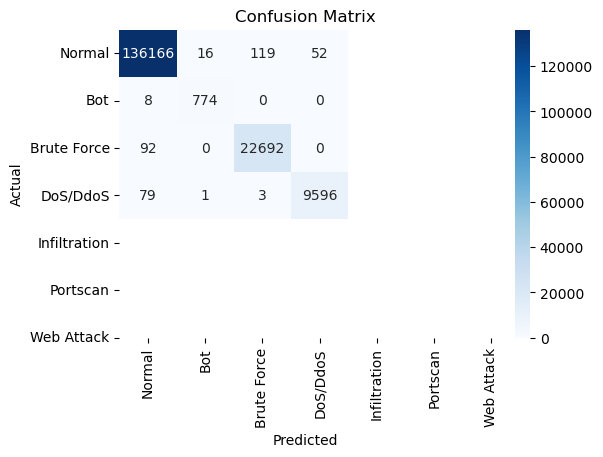

In [90]:
rt_start_fg7 = time.time()
# Training model with 10 fold cross-validation
rt_model_fg7 = RandomForestClassifier(n_estimators = 1)

# Performing cross-validation and making predictions
param_grid = {'n_estimators': [1]}
rt_grid_cv_fg7 = GridSearchCV(rt_model_fg7, param_grid, cv = 10)
rt_grid_cv_fg7.fit(X_train, y_train_encoded.values.ravel())
rt_pred_fg7 = rt_grid_cv_fg7.predict(X_test) 
rt_end_fg7 = time.time()

# Confusion Matrix
rt_cm_fg7 = confusion_matrix(y_test_encoded.values.ravel(), rt_pred_fg7)
plt.figure(figsize=(6, 4))
sns.heatmap(rt_cm_fg7, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [91]:
## Model Evaluation
# Accuracy
rt_accuracy_fg7 = accuracy_score(y_test_encoded.values.ravel(), rt_pred_fg7)

# Extract values from the confusion matrix
TN_rt_fg7, FP_rt_fg7, FN_rt_fg7, TP_rt_fg7 = rt_cm_fg7[0][0], rt_cm_fg7[0][1], rt_cm_fg7[1][0], rt_cm_fg7[1][1]

# Calculate False Positive Rate (FPR)
FPR_rt_fg7 = FP_rt_fg7 / (FP_rt_fg7 + TN_rt_fg7)

# Calculate True Positive Rate (TPR) or Recall
TPR_rt_fg7 = TP_rt_fg7 / (TP_rt_fg7 + FN_rt_fg7)

# Calculate Precision
Precision_rt_fg7 = TP_rt_fg7 / (TP_rt_fg7 + FP_rt_fg7)

# Calculate F1 Score
F1_score_rt_fg7 = 2 * (Precision_rt_fg7 * TPR_rt_fg7) / (Precision_rt_fg7 + TPR_rt_fg7)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_rt_fg7 = (FP_rt_fg7 + FN_rt_fg7) / (TN_rt_fg7 + FP_rt_fg7 + FN_rt_fg7 + TP_rt_fg7)


# Print the results
print('Random Tree Accuracy', rt_accuracy_fg7)
print("Random Tree FPR:", FPR_rt_fg7)
print("Random Tree TPR (Recall):", TPR_rt_fg7)
print("Random Tree Precision:", Precision_rt_fg7)
print("Random Tree F1 Score:", F1_score_rt_fg7)
print("Random Tree PIC:", PIC_rt_fg7)
print("Random Tree Execution Time:", rt_end_fg7 - rt_start_fg7) 

Random Tree Accuracy 0.9978183704996522
Random Tree FPR: 0.0001174898297866091
Random Tree TPR (Recall): 0.989769820971867
Random Tree Precision: 0.979746835443038
Random Tree F1 Score: 0.9847328244274809
Random Tree PIC: 0.00017522852720422885
Random Tree Execution Time: 11.608709812164307


#### Naive Bayes

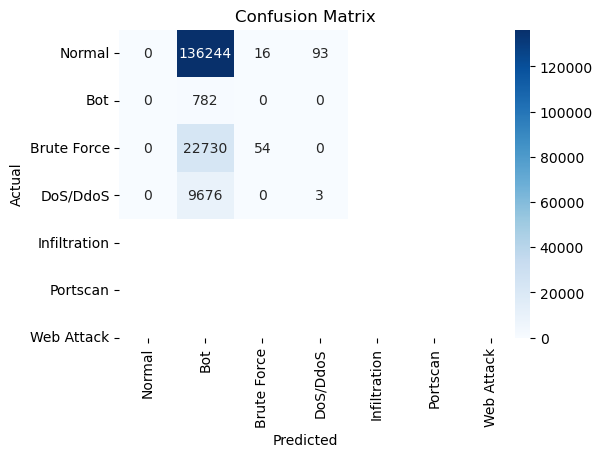

In [92]:
nb_start_fg7 = time.time()
# Training model with 10 fold cross-validation
nb_model_fg7 = GaussianNB()

# Performing cross-validation and making predictions
param_grid = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
nb_grid_cv_fg7 = GridSearchCV(nb_model_fg7, param_grid, cv = 10)
nb_grid_cv_fg7.fit(X_train, y_train_encoded.values.ravel())
nb_pred_fg7 = nb_grid_cv_fg7.predict(X_test) 
nb_end_fg7 = time.time()

# Confusion Matrix
nb_cm_fg7 = confusion_matrix(y_test_encoded.values.ravel(), nb_pred_fg7)
plt.figure(figsize=(6, 4))
sns.heatmap(nb_cm_fg7, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [93]:
## Model Evaluation
# Accuracy
nb_accuracy_fg7 = accuracy_score(y_test_encoded.values.ravel(), nb_pred_fg7)

# Extract values from the confusion matrix
TN_nb_fg7, FP_nb_fg7, FN_nb_fg7, TP_nb_fg7 = nb_cm_fg7[0][0], nb_cm_fg7[0][1], nb_cm_fg7[1][0], nb_cm_fg7[1][1]

# Calculate False Positive Rate (FPR)
FPR_nb_fg7 = FP_nb_fg7 / (FP_nb_fg7 + TN_nb_fg7)

# Calculate True Positive Rate (TPR) or Recall
TPR_nb_fg7 = TP_nb_fg7 / (TP_nb_fg7 + FN_nb_fg7)

# Calculate Precision
Precision_nb_fg7 = TP_nb_fg7 / (TP_nb_fg7 + FP_nb_fg7)

# Calculate F1 Score
F1_score_nb_fg7 = 2 * (Precision_nb_fg7 * TPR_nb_fg7) / (Precision_nb_fg7 + TPR_nb_fg7)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_nb_fg7 = (FP_nb_fg7 + FN_nb_fg7) / (TN_nb_fg7 + FP_nb_fg7 + FN_nb_fg7 + TP_nb_fg7)


# Print the results
print('Naive Bayes Accuracy', nb_accuracy_fg7)
print("Naive Bayes FPR:", FPR_nb_fg7)
print("Naive Bayes TPR (Recall):", TPR_nb_fg7)
print("Naive Bayes Precision:", Precision_nb_fg7)
print("Naive Bayes F1 Score:", F1_score_nb_fg7)
print("Naive Bayes PIC:", PIC_nb_fg7)
print("Naive Bayes Execution Time:", nb_end_fg7 - nb_start_fg7) 

Naive Bayes Accuracy 0.004946992299437494
Naive Bayes FPR: 1.0
Naive Bayes TPR (Recall): 1.0
Naive Bayes Precision: 0.005706946127012392
Naive Bayes F1 Score: 0.011349123418088934
Naive Bayes PIC: 0.9942930538729876
Naive Bayes Execution Time: 19.26407217979431


#### XGBoost

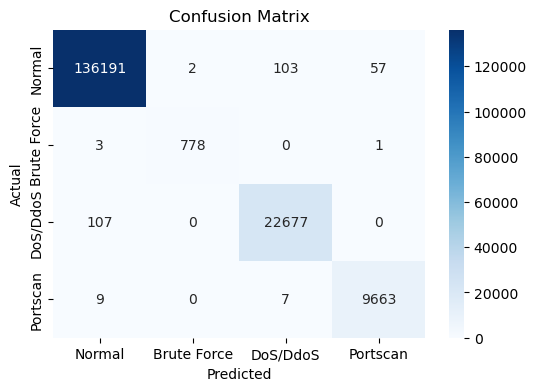

In [148]:
xgb_start_fg7 = time.time()
xgb_model_fg7 = XGBClassifier()
param_grid = {'max_depth': [3], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100], 'objective': ['binary:logistic'], 'eval_metric': ['logloss'], 'random_state': [0], 'n_jobs': [-1]}
xgb_grid_cv_fg7 = GridSearchCV(xgb_model_fg7, param_grid, cv = 10)
xgb_grid_cv_fg7.fit(X_train, y_train_encoded.values.ravel())
xgb_pred_fg7 = xgb_grid_cv_fg7.predict(X_test) 
xgb_end_fg7 = time.time()

# Confusion Matrix
xgb_cm_fg7 = confusion_matrix(y_test_encoded.values.ravel(), xgb_pred_fg7)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm_fg7, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [149]:
## Model Evaluation
# Accuracy
xgb_accuracy_fg7 = accuracy_score(y_test_encoded.values.ravel(), xgb_pred_fg7)

# Extract values from the confusion matrix
TN_xgb_fg7, FP_xgb_fg7, FN_xgb_fg7, TP_xgb_fg7 = xgb_cm_fg7[0][0], xgb_cm_fg7[0][1], xgb_cm_fg7[1][0], xgb_cm_fg7[1][1]

# Calculate False Positive Rate (FPR)
FPR_xgb_fg7 = FP_xgb_fg7 / (FP_xgb_fg7 + TN_xgb_fg7)

# Calculate True Positive Rate (TPR) or Recall
TPR_xgb_fg7 = TP_xgb_fg7 / (TP_xgb_fg7 + FN_xgb_fg7)

# Calculate Precision
Precision_xgb_fg7 = TP_xgb_fg7 / (TP_xgb_fg7 + FP_xgb_fg7)

# Calculate F1 Score
F1_score_xgb_fg7 = 2 * (Precision_xgb_fg7 * TPR_xgb_fg7) / (Precision_xgb_fg7 + TPR_xgb_fg7)

# Calculate Percentage of Incorrectly Classified (PIC)
PIC_xgb_fg7 = (FP_xgb_fg7 + FN_xgb_fg7) / (TN_xgb_fg7 + FP_xgb_fg7 + FN_xgb_fg7 + TP_xgb_fg7)


# Print the results
print('XGBoost Accuracy', xgb_accuracy_fg7)
print("XGBoost FPR:", FPR_xgb_fg7)
print("XGBoost TPR (Recall):", TPR_xgb_fg7)
print("XGBoost Precision:", Precision_xgb_fg7)
print("XGBoost F1 Score:", F1_score_xgb_fg7)
print("XGBoost PIC:", PIC_xgb_fg7)
print("XGBoost Execution Time:", xgb_end_fg7 - xgb_start_fg7) 


XGBoost Accuracy 0.9982959704713499
XGBoost FPR: 1.4685042549910788e-05
XGBoost TPR (Recall): 0.9961587708066582
XGBoost Precision: 0.9974358974358974
XGBoost F1 Score: 0.9967969250480462
XGBoost PIC: 3.65032779943639e-05
XGBoost Execution Time: 1962.883986234665


# Result Visualizations

## Accuracy

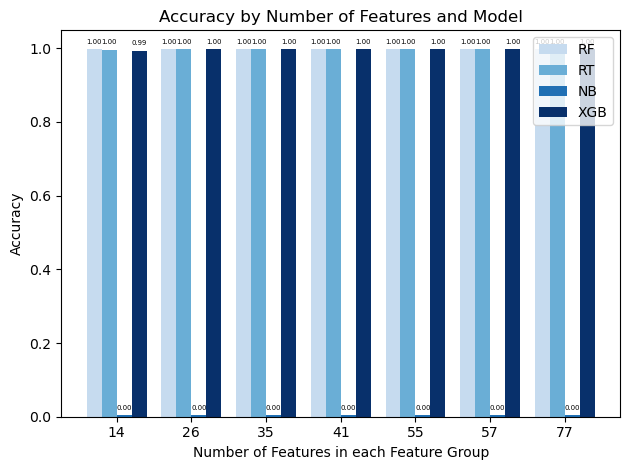

In [160]:
# Data
categories = ['14', '26', '35', '41', '55', '57', '77']
models = ['RF', 'RT', 'NB', 'XGB']
accuracies = np.array([[rf_accuracy_fg1, rt_accuracy_fg1, nb_accuracy_fg1, xgb_accuracy_fg1],
                       [rf_accuracy_fg2, rt_accuracy_fg2, nb_accuracy_fg2, xgb_accuracy_fg2],
                       [rf_accuracy_fg3, rt_accuracy_fg3, nb_accuracy_fg3, xgb_accuracy_fg3],
                       [rf_accuracy_fg4, rt_accuracy_fg4, nb_accuracy_fg4, xgb_accuracy_fg4],
                       [rf_accuracy_fg5, rt_accuracy_fg5, nb_accuracy_fg5, xgb_accuracy_fg5],
                       [rf_accuracy_fg6, rt_accuracy_fg6, nb_accuracy_fg6, xgb_accuracy_fg6],
                       [rf_accuracy_fg7, rt_accuracy_fg7, nb_accuracy_fg7, xgb_accuracy_fg7]])

# Plotting
bar_width = 0.2
index = np.arange(len(categories))
colors = plt.cm.Blues(np.linspace(0.25, 1, len(models)))  # Generate shades of blue

fig, ax = plt.subplots()
for i, model in enumerate(models):
    bars = ax.bar(index + i * bar_width, scores[:, i], bar_width, label=model, color=colors[i])
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=5)  # Adjust the fontsize here

ax.set_xlabel('Number of Features in each Feature Group')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Number of Features and Model')
ax.set_xticks(index + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()


## F1 Score

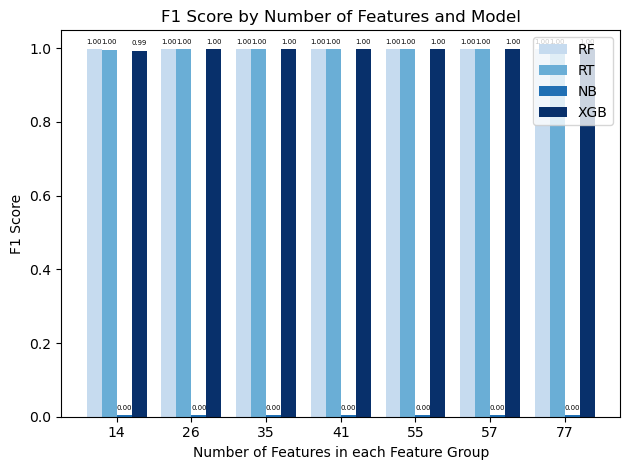

In [162]:
# Data
categories = ['14', '26', '35', '41', '55', '57', '77']
models = ['RF', 'RT', 'NB', 'XGB']
f1_scores = np.array([[F1_score_rf_fg1, F1_score_rt_fg1, F1_score_nb_fg1, F1_score_xgb_fg1],
                      [F1_score_rf_fg2, F1_score_rt_fg2, F1_score_nb_fg2, F1_score_xgb_fg2],
                      [F1_score_rf_fg3, F1_score_rt_fg3, F1_score_nb_fg3, F1_score_xgb_fg3],
                      [F1_score_rf_fg4, F1_score_rt_fg4, F1_score_nb_fg4, F1_score_xgb_fg4],
                      [F1_score_rf_fg5, F1_score_rt_fg5, F1_score_nb_fg5, F1_score_xgb_fg5],
                      [F1_score_rf_fg6, F1_score_rt_fg6, F1_score_nb_fg6, F1_score_xgb_fg6],
                      [F1_score_rf_fg7, F1_score_rt_fg7, F1_score_nb_fg7, F1_score_xgb_fg7],
                      ])

# Plotting
bar_width = 0.2
index = np.arange(len(categories))
colors = plt.cm.Blues(np.linspace(0.25, 1, len(models)))  # Generate shades of blue

fig, ax = plt.subplots()
for i, model in enumerate(models):
    bars = ax.bar(index + i * bar_width, scores[:, i], bar_width, label=model, color=colors[i])
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=5)  # Adjust the fontsize here

ax.set_xlabel('Number of Features in each Feature Group')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Number of Features and Model')
ax.set_xticks(index + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()


## Execution Time

In [180]:
execution_times = np.array([[rf_end_fg1 - rf_start_fg1, rt_end_fg1 - rt_start_fg1, nb_end_fg1 - nb_start_fg1, xgb_end_fg1 - xgb_start_fg1],
                            [rf_end_fg2 - rf_start_fg2, rt_end_fg2 - rt_start_fg2, nb_end_fg2 - nb_start_fg2, xgb_end_fg2 - xgb_start_fg2]])
execution_times

array([[ 539.69358516,    5.97343421,    2.44697285,  731.45855594],
       [ 738.97723508,    8.53786922,    3.42707586, 1025.22063613]])

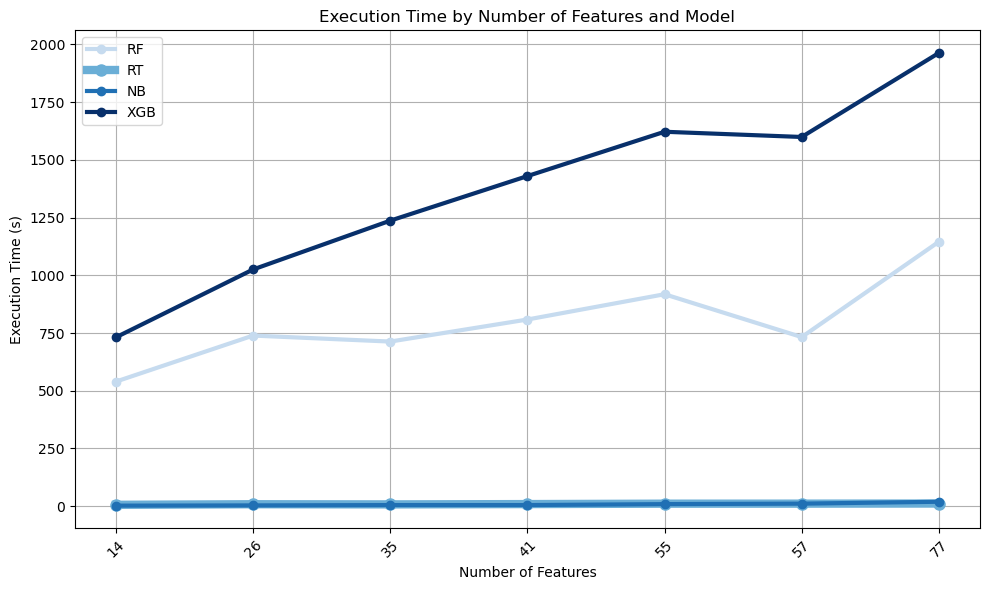

In [198]:
import numpy as np
import matplotlib.pyplot as plt

# Data
categories = ['14', '26', '35', '41', '55', '57', '77']
models = ['RF', 'RT', 'NB', 'XGB']
execution_times = np.array([[rf_end_fg1 - rf_start_fg1, rt_end_fg1 - rt_start_fg1, nb_end_fg1 - nb_start_fg1, xgb_end_fg1 - xgb_start_fg1],
                            [rf_end_fg2 - rf_start_fg2, rt_end_fg2 - rt_start_fg2, nb_end_fg2 - nb_start_fg2, xgb_end_fg2 - xgb_start_fg2],
                            [rf_end_fg3 - rf_start_fg3, rt_end_fg3 - rt_start_fg3, nb_end_fg3 - nb_start_fg3, xgb_end_fg3 - xgb_start_fg3],
                            [rf_end_fg4 - rf_start_fg4, rt_end_fg4 - rt_start_fg4, nb_end_fg4 - nb_start_fg4, xgb_end_fg4 - xgb_start_fg4],
                            [rf_end_fg5 - rf_start_fg5, rt_end_fg5 - rt_start_fg5, nb_end_fg5 - nb_start_fg5, xgb_end_fg5 - xgb_start_fg5],
                            [732.4682080745697, rt_end_fg6 - rt_start_fg6, nb_end_fg6 - nb_start_fg6, xgb_end_fg6 - xgb_start_fg6],
                            [1145.308856010437, rt_end_fg7 - rt_start_fg7, nb_end_fg7 - nb_start_fg7, xgb_end_fg7 - xgb_start_fg7]])

# Plotting
index = np.arange(len(categories))
colors = plt.cm.Blues(np.linspace(0.25, 1, len(models)))  # Generate shades of blue

plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    if i == 1:  # Check if it's the third line (indexing starts from 0)
        plt.plot(index, execution_times[:, i], label=model, color=colors[i], linewidth=6, marker='o', markersize=8)  # Set a thicker line width
    else:
        plt.plot(index, execution_times[:, i], label=model, color=colors[i], linewidth=3, marker='o')

plt.xlabel('Number of Features')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time by Number of Features and Model')
plt.xticks(index, categories, rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
